<a href="https://colab.research.google.com/github/emilyberlinghoff/DS3000/blob/main/Homework%208%20-%20Clustering/251287809_H08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 8: Clustering

## Follow These Steps Before Submitting
Once you are finished, ensure to complete the following steps.

1.  Restart your kernel by clicking 'Kernel' > 'Restart & Run All'.

2.  Fix any errors which result from this.

3.  Repeat steps 1. and 2. until your notebook runs without errors.

4.  Submit your completed notebook to OWL by the deadline.

## Mall Customers Dataset

In this assignment, you will work on customer segmentation using clustering techniques.

The dataset for this assignment is the **Mall Customers Dataset**, which contains customer data collected from a shopping mall. It includes:

- **CustomerID**: Unique identifier for each customer (not useful for clustering).
- **Gender**: Male or Female.
- **Age**: Age of the customer.
- **Annual Income (k$)**: Annual income in thousands of dollars.
- **Spending Score (1-100)**: A metric indicating customer spending habits.

The goal is to segment customers based on their characteristics using different clustering methods.


In [1]:
# Install yellowbricks if you don't already have it or are in colab
!pip install yellowbrick

In [2]:
import numpy as np
import polars as pl
import pandas as pd

# Clustering
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from yellowbrick.cluster.elbow import kelbow_visualizer

# Plotting
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [3]:
# Uncomment the line below if you are using Google colab
# !gdown https://drive.google.com/uc?id=1Jo9YoLfvey-y6hIQK_pii-XUCJNAE_TE

1. Load the CSV file. Display the summary statistics for the dataset and check if there are any null values in the dataset. Use polars unless your operators do not allow it (transforming them to pandas or numpy at that stage).

In [4]:
data = pl.read_csv('Mall_Customers.csv')
data.describe()

statistic,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
str,f64,str,f64,f64,f64
"""count""",200.0,"""200""",200.0,200.0,200.0
"""null_count""",0.0,"""0""",0.0,0.0,0.0
"""mean""",100.5,null,38.85,60.56,50.2
"""std""",57.879185,null,13.969007,26.264721,25.823522
"""min""",1.0,"""Female""",18.0,15.0,1.0
"""25%""",51.0,null,29.0,42.0,35.0
"""50%""",101.0,null,36.0,62.0,50.0
"""75%""",150.0,null,49.0,78.0,73.0
"""max""",200.0,"""Male""",70.0,137.0,99.0


In [5]:
data.null_count()

CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
u32,u32,u32,u32,u32
0,0,0,0,0


2. For the clustering analyses, consider only the numerical variables. Therefore you should drop 'Genre' from the dataset. Standardize the remaining variables, excluding the ID, ensuring they have mean of zero and standard deviation of one.

In the following lines you should:

- Update the dataset to include only numerical features and display the first 10 rows of the updated dataset.

- Standardize the features.

In [6]:
# Drop 'Genre' from the dataset
data = data.drop('Genre')

# Display first 10 rows
data.head(10)

CustomerID,Age,Annual Income (k$),Spending Score (1-100)
i64,i64,i64,i64
1,19,15,39
2,21,15,81
3,20,16,6
4,23,16,77
5,31,17,40
6,22,17,76
7,35,18,6
8,23,18,94
9,64,19,3


In [7]:
# Standardize the remaining variables, excluding the ID, ensuring they have a mean of zero and a standard deviation of one
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
data.describe()

statistic,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
str,f64,f64,f64,f64
"""count""",200.0,200.0,200.0,200.0
"""null_count""",0.0,0.0,0.0,0.0
"""mean""",100.5,38.85,60.56,50.2
"""std""",57.879185,13.969007,26.264721,25.823522
"""min""",1.0,18.0,15.0,1.0
"""25%""",51.0,29.0,42.0,35.0
"""50%""",101.0,36.0,62.0,50.0
"""75%""",150.0,49.0,78.0,73.0
"""max""",200.0,70.0,137.0,99.0


## K-means

3. Use the K-means method to perform clustering on the scaled data from Q2, setting `random_state = 2025`. Determine the optimal number of clusters using the [KelbowVisualizer](https://www.scikit-yb.org/en/latest/api/cluster/elbow.html)  function with `k=(2,12)`.



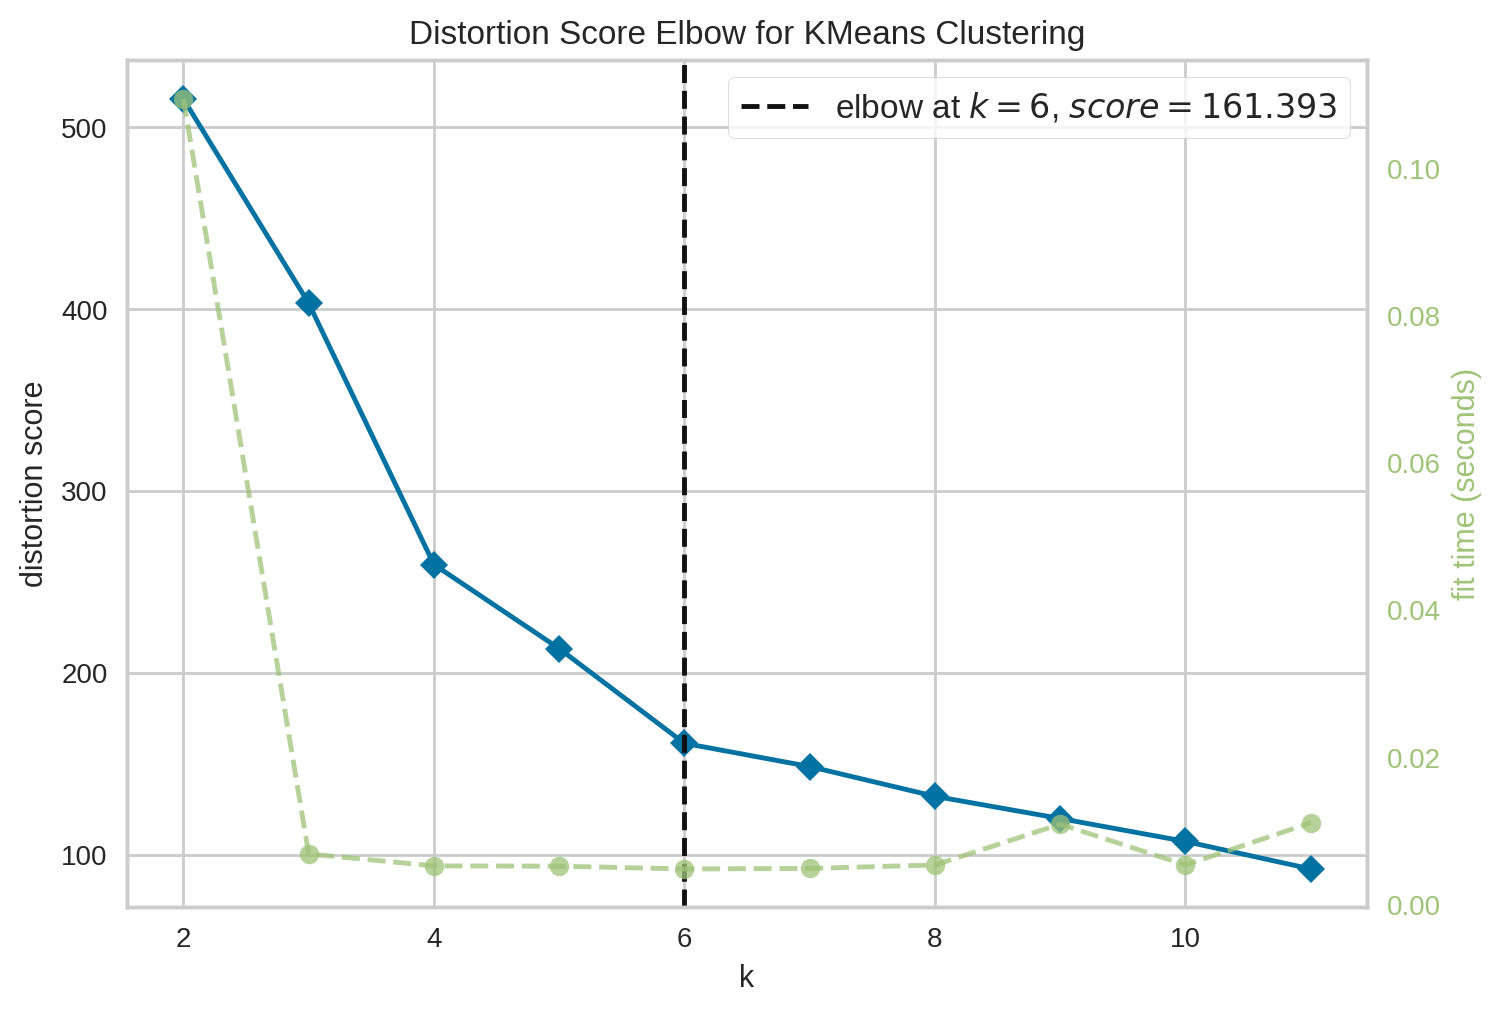

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=11, random_state=2025), k=(2, 12))

In [8]:
# Use the K-means method to perform clustering on the scaled data from Q2, setting `random_state = 2025`
kmeans = KMeans(random_state=2025)
kelbow_visualizer(kmeans, X=data_scaled, k=(2,12))

**Written answer: What is the optimal number of clusters using the elbow method?**

The optimal number of clusters using the elbow method is 6.

4. Fit a K-means model on the scaled data using the optimal number of clusters identified in Q3. Then, visualize the resulting clusters using a scatterplot matrix (`sns.pairplot`).

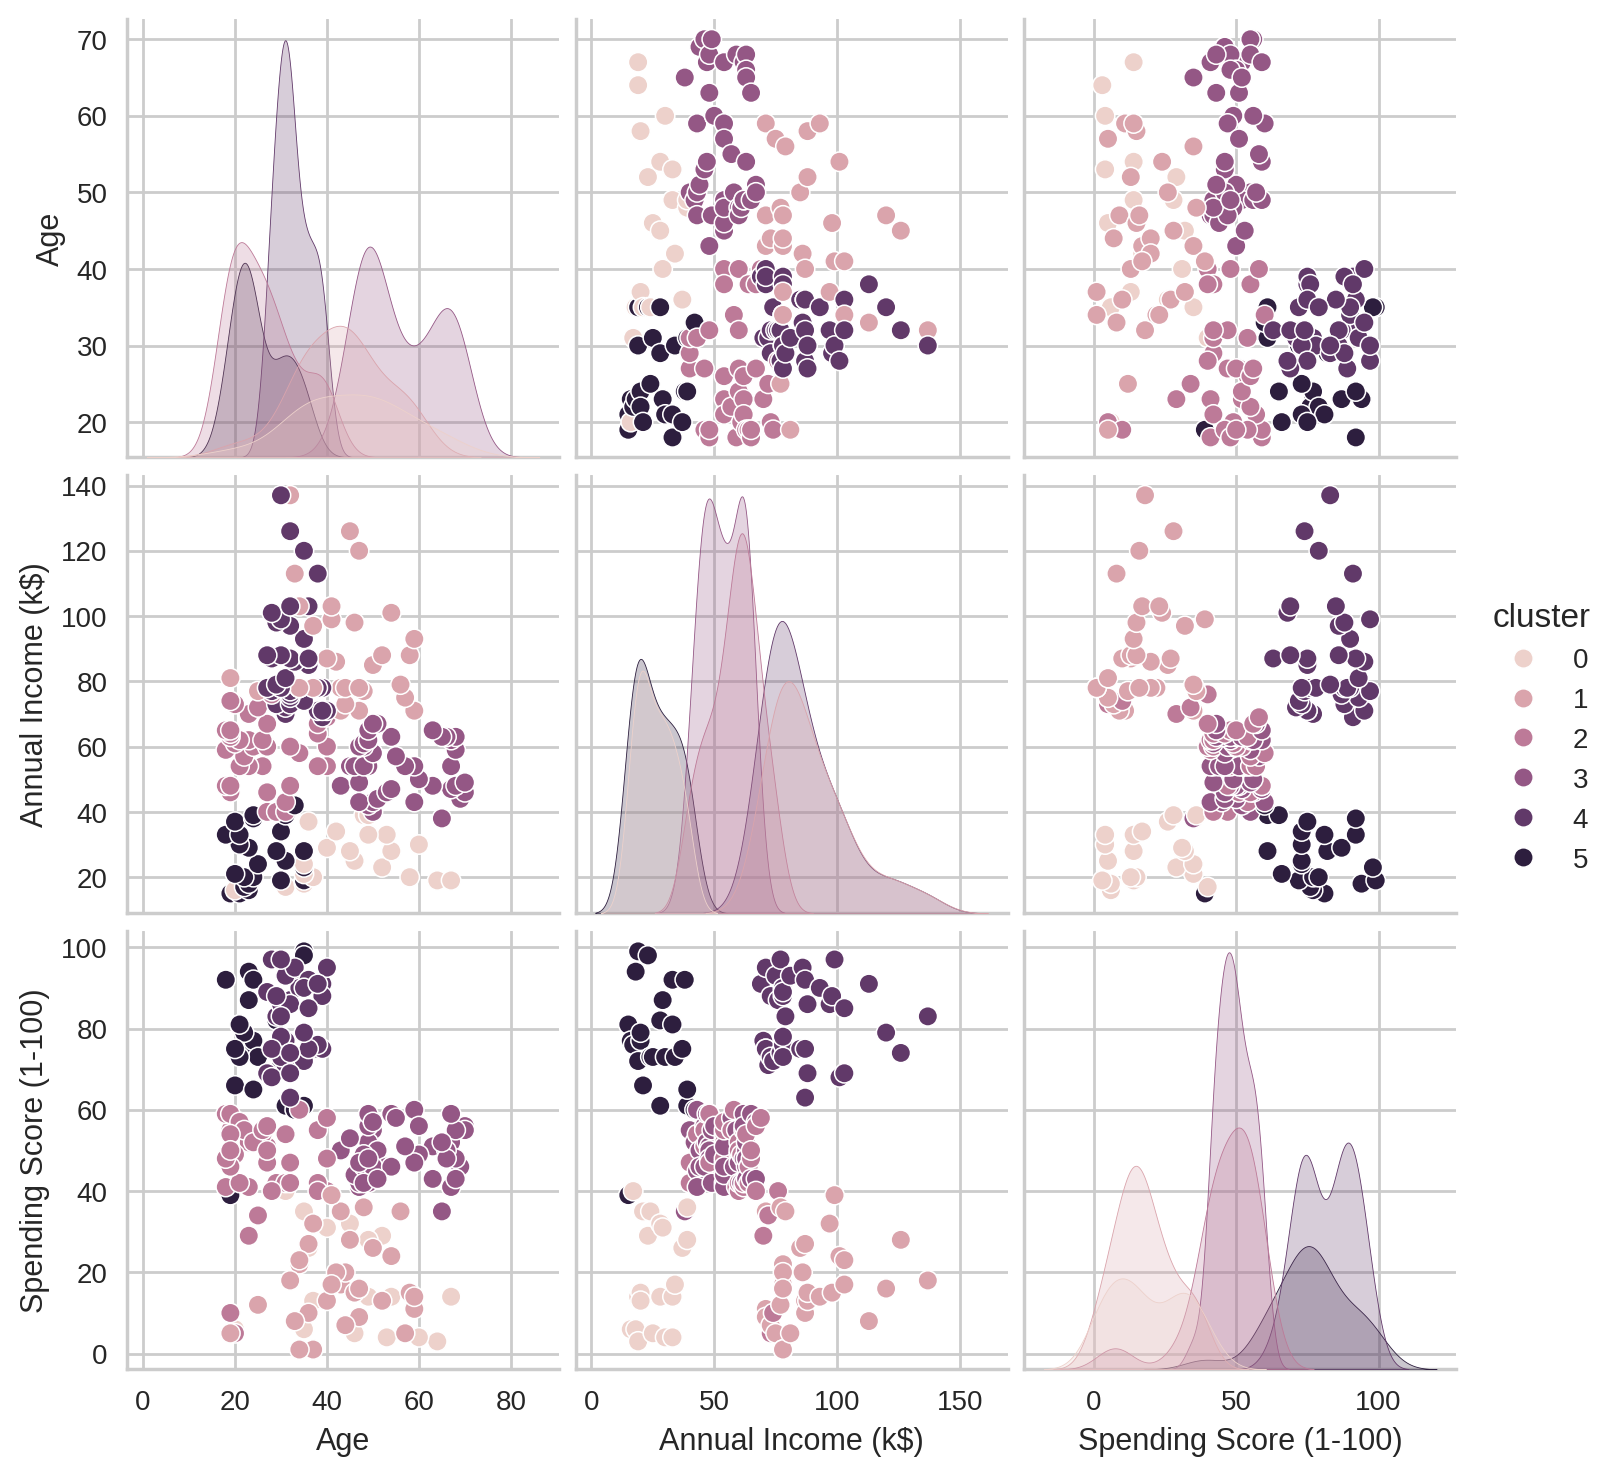

In [9]:
# Fit a K-means model on the scaled data using the optimal number of clusters identified in Q3
kmeans = KMeans(n_clusters=6, random_state=2025)
kmeans.fit(data_scaled)

# Convert to Pandas DataFrame for compatibility with seaborn
data_pd = data.to_pandas()
data_pd['cluster'] = kmeans.labels_

# Visualize the resulting clusters using a scatterplot matrix `sns.pairplot`
sns.pairplot(data_pd, hue="cluster", vars=["Age", "Annual Income (k$)", "Spending Score (1-100)"])
plt.show()

5. The objective of any cluster analysis over customer data is to create a reasonable segmentation of your customers. Using the clusters from Q4, create a table showing the average values per variable (Age, Annual income, and Spending scores) for each cluster. Use the original, non-scaled variables. Interpret the characteristics of each cluster by analyzing their defining features, such as whether they represent high-income spenders, budget-conscious customers, or younger versus older groups.

In [10]:
# Using the clusters from Q4, create a table showing the average values per variable (Age, Annual income, and Spending scores) for each cluster
data_pd['cluster'] = kmeans.labels_
data_pd.groupby('cluster').mean()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
cluster,,,,
0,23.190476,45.523810,26.285714,19.380952
1,166.090909,43.030303,89.121212,17.878788
2,94.736842,26.342105,58.394737,46.342105
3,82.022727,56.340909,53.704545,49.386364
4,162.000000,32.692308,86.538462,82.128205
5,24.200000,25.560000,26.480000,76.240000


**Written answer:**

**Cluster 0**: Has the lowest annual income and a pretty low spending score. These middle-aged people are probably budget-conscious and may be less interested in non-essential items.

**Cluster 1**: Similar in age and spending score at cluster 1 and in fact has the lowest spending score. However, their annual income is the highest of all the clusters. Since they are a little younger than cluster 0, this cluster might contain less retired people and therefore a greater portion are making bank. Probably for the same reason as clsuter 1, whatever that reason may be,they are budget conscious.

**Cluster 2**: Very young, average annual income and average spending score. There is a huge monetary difference between cluster 2 and 5 despite the mean age being less than a year apart. They might have more students graduated from school and in the workforce. And since they aren't spendning money on tuition (and going out to bars), their spending score is lower. Besides school, they probably having similar spending habits like bills, groceries, sources of entertainment, etc.

**Cluster 3**: Oldest group and they have an average spending score, but it's very high compared to the groups similar in age. They might contain a lot of retired folks who are spending their retirement money on fancy cruises and cuban cigars.

**Cluster 4**: Highest spending score and on average, they are at the age of being settled into their careers. They are at the age where they have bought their first home and have a kid or two. Kids are expensive. End of statement.

**Cluster 5**: Youngest group, pretty much the lowest annual income, and very high spending score. Probbaly spending money on tuitition or on having fun cause they're out of their parents house. I would encourage the former and mom if you're watching, my income goes towards my tuition, rent, and groceries.

## Agglomerative clustering

6. Use Agglomerative Clustering with `linkage='average'` to determine the best number of clusters (between 3 and 7) using silhouette analysis.

For each number of clusters:

- Compute and print the average silhouette score.
- Generate and display a silhouette plot.

For n_clusters = 3, the average silhouette score is 0.3334603642389694


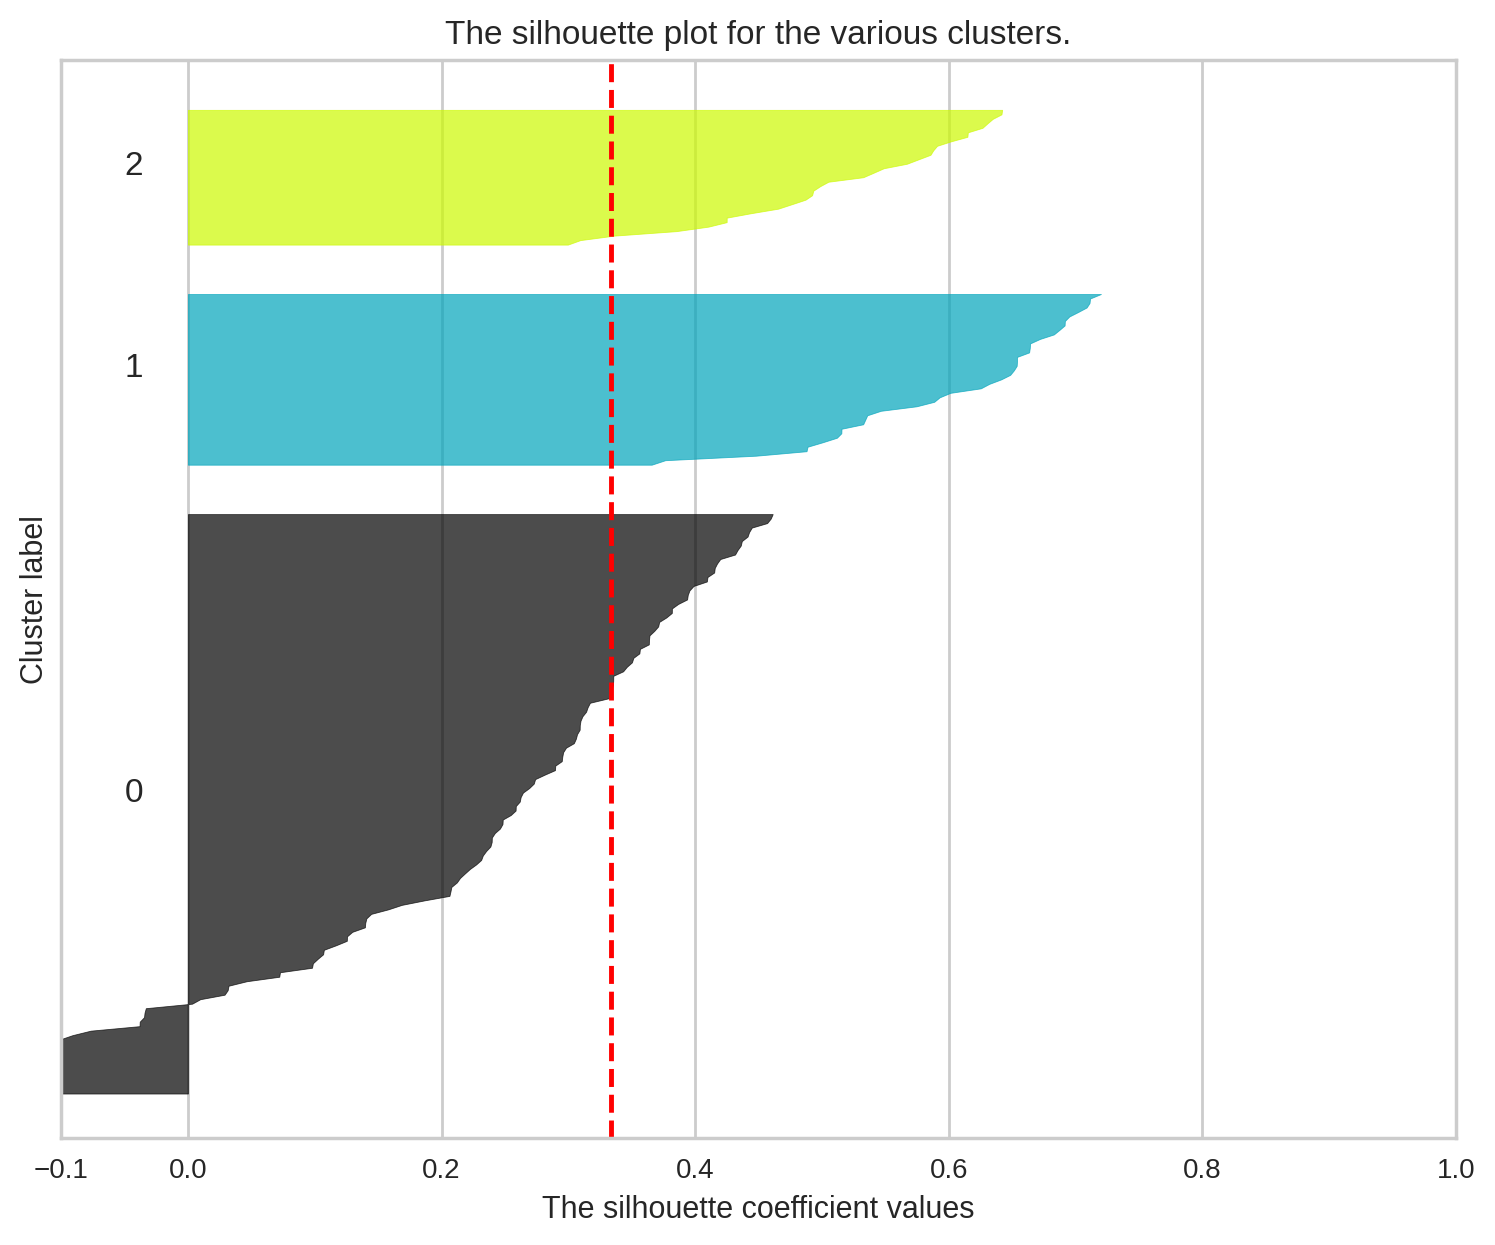

For n_clusters = 4, the average silhouette score is 0.3773516494061883


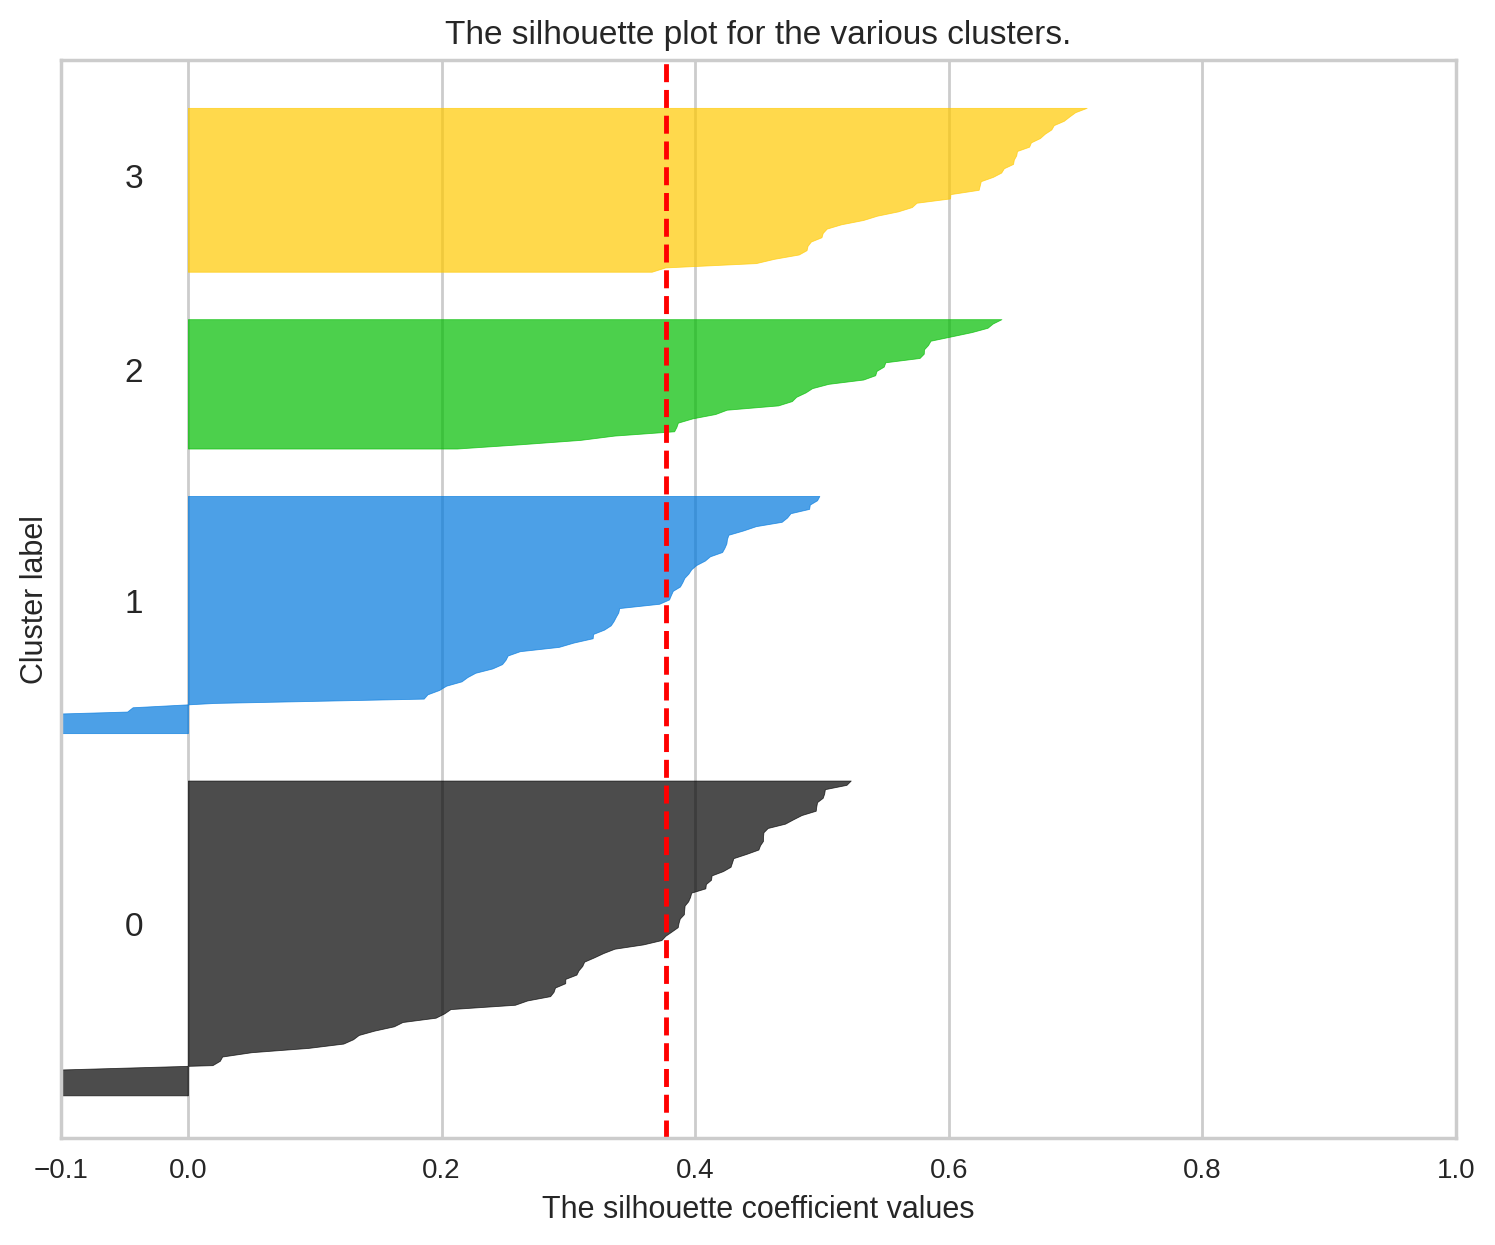

For n_clusters = 5, the average silhouette score is 0.401363129175431


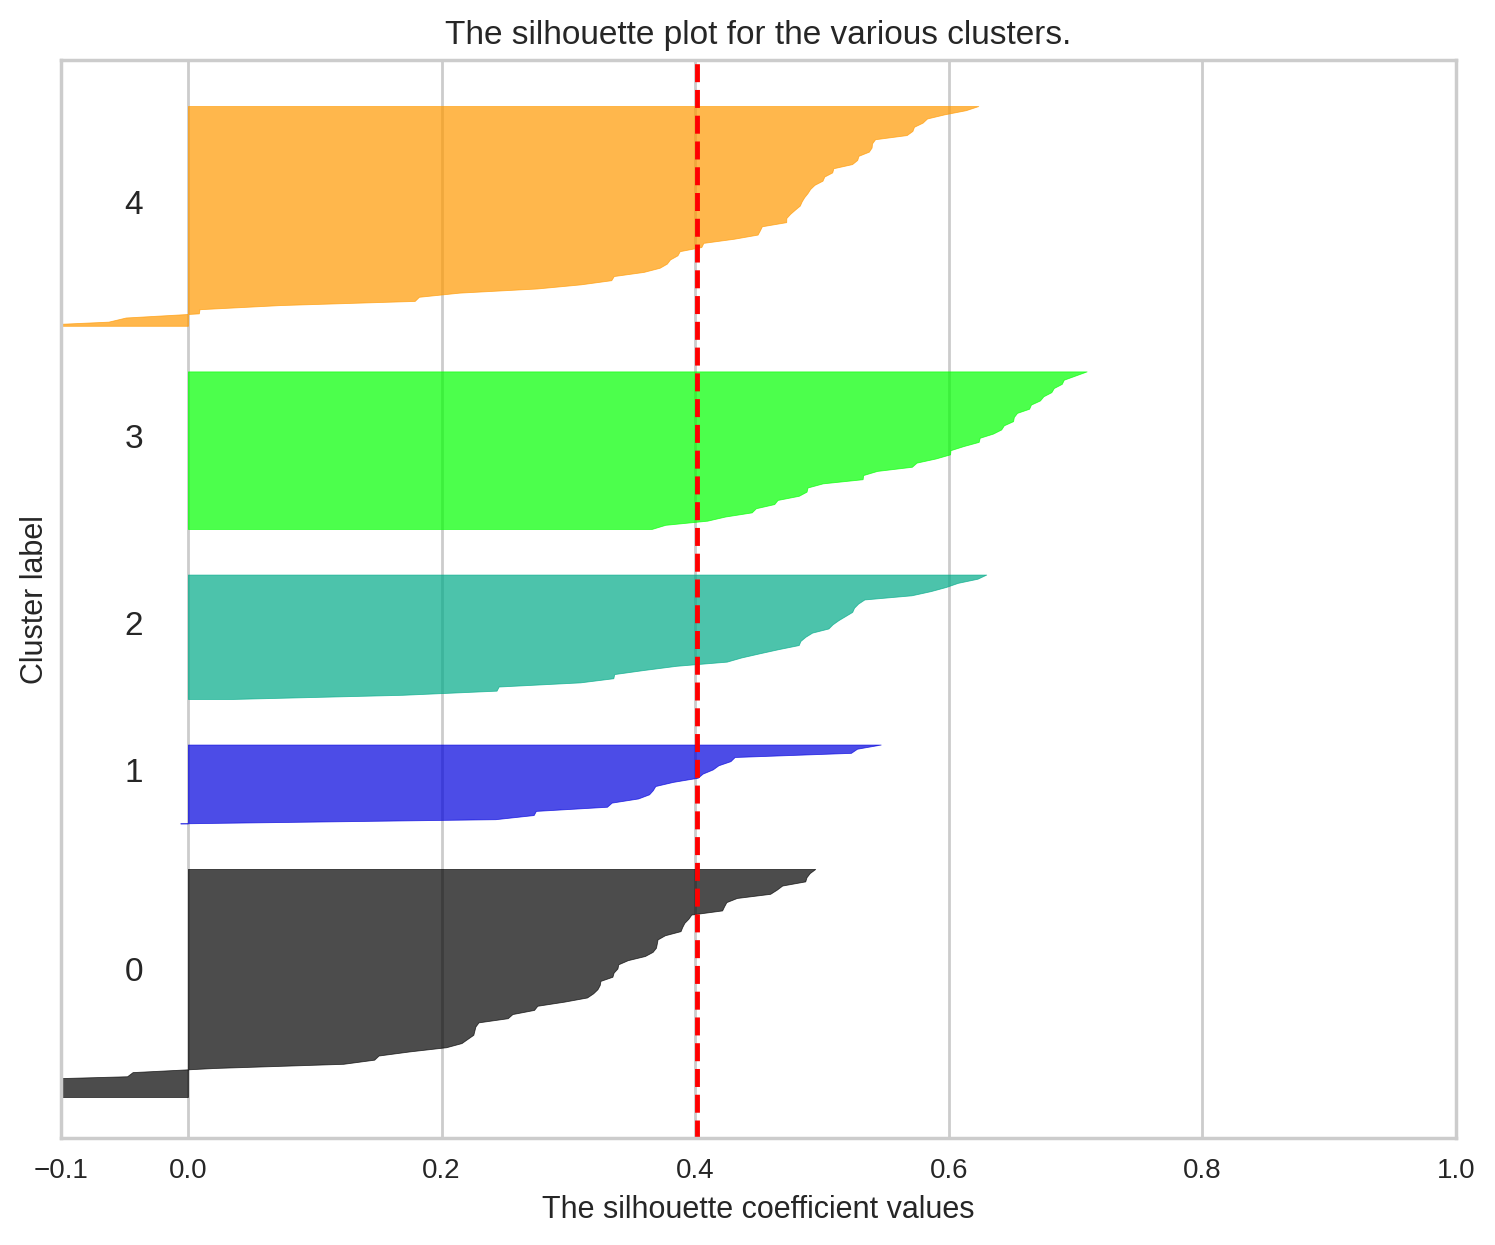

For n_clusters = 6, the average silhouette score is 0.43019501486902373


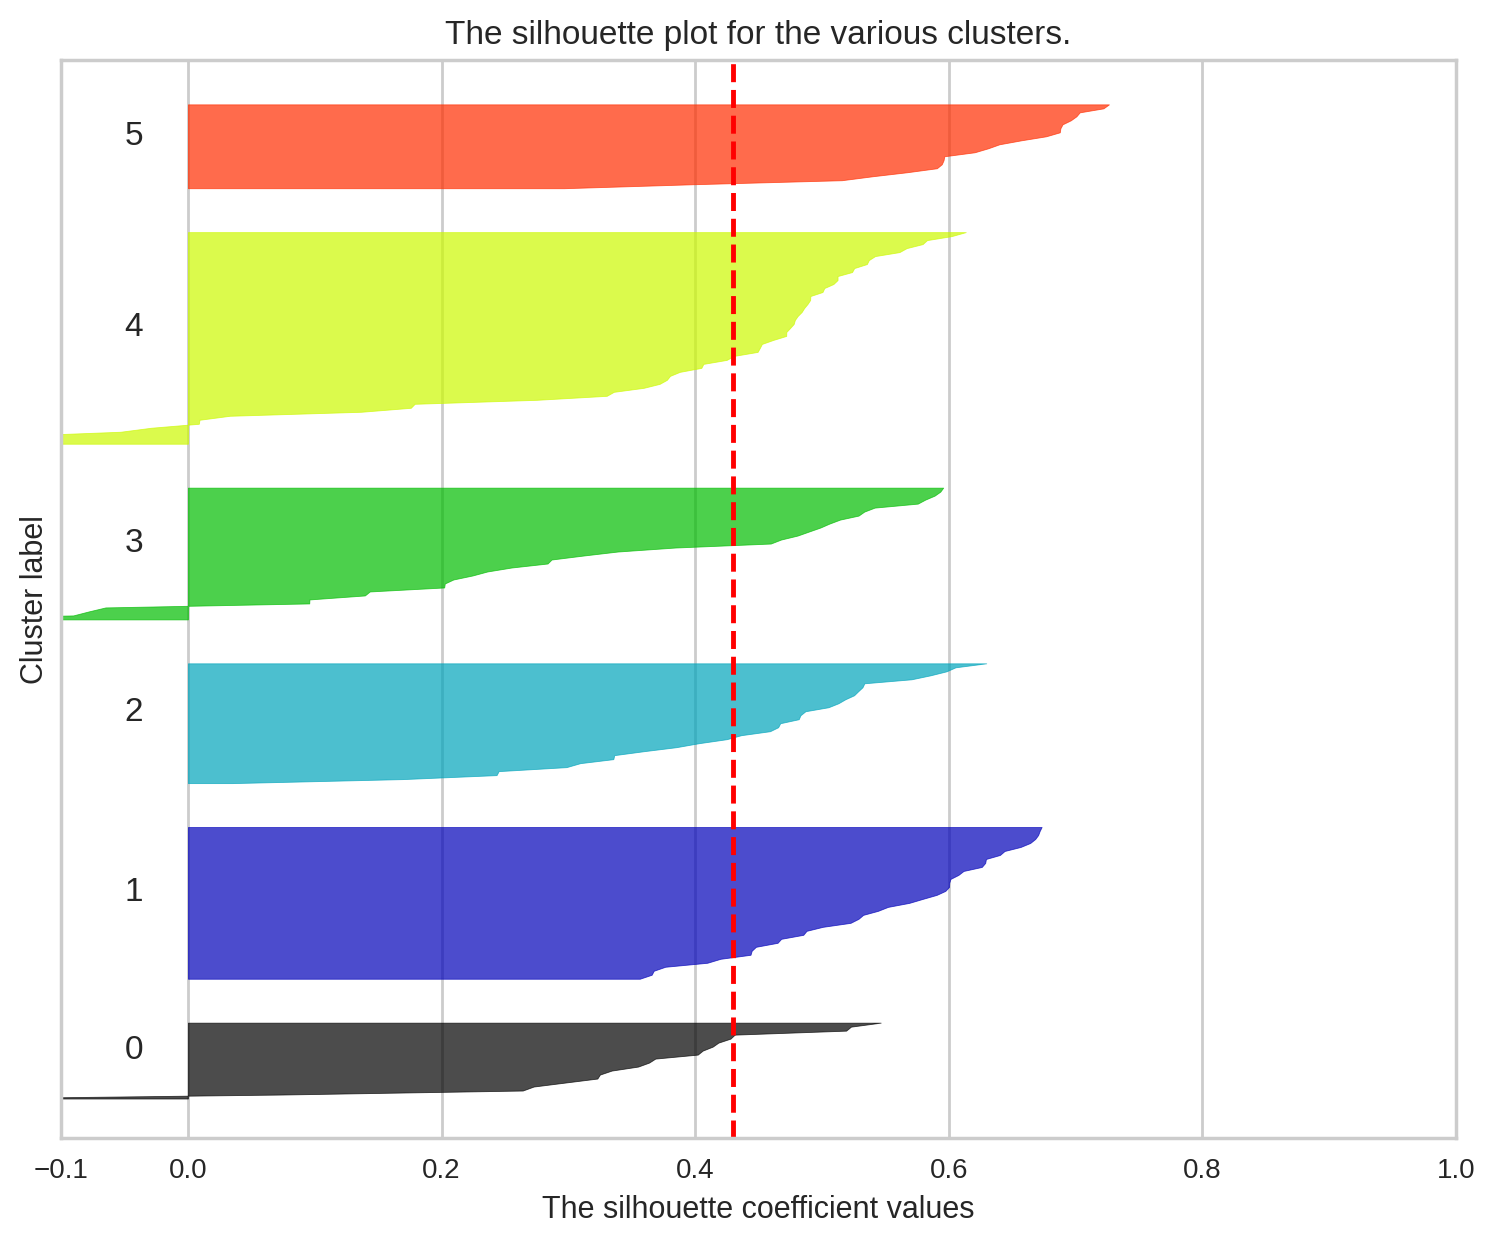

For n_clusters = 7, the average silhouette score is 0.4207718817846796


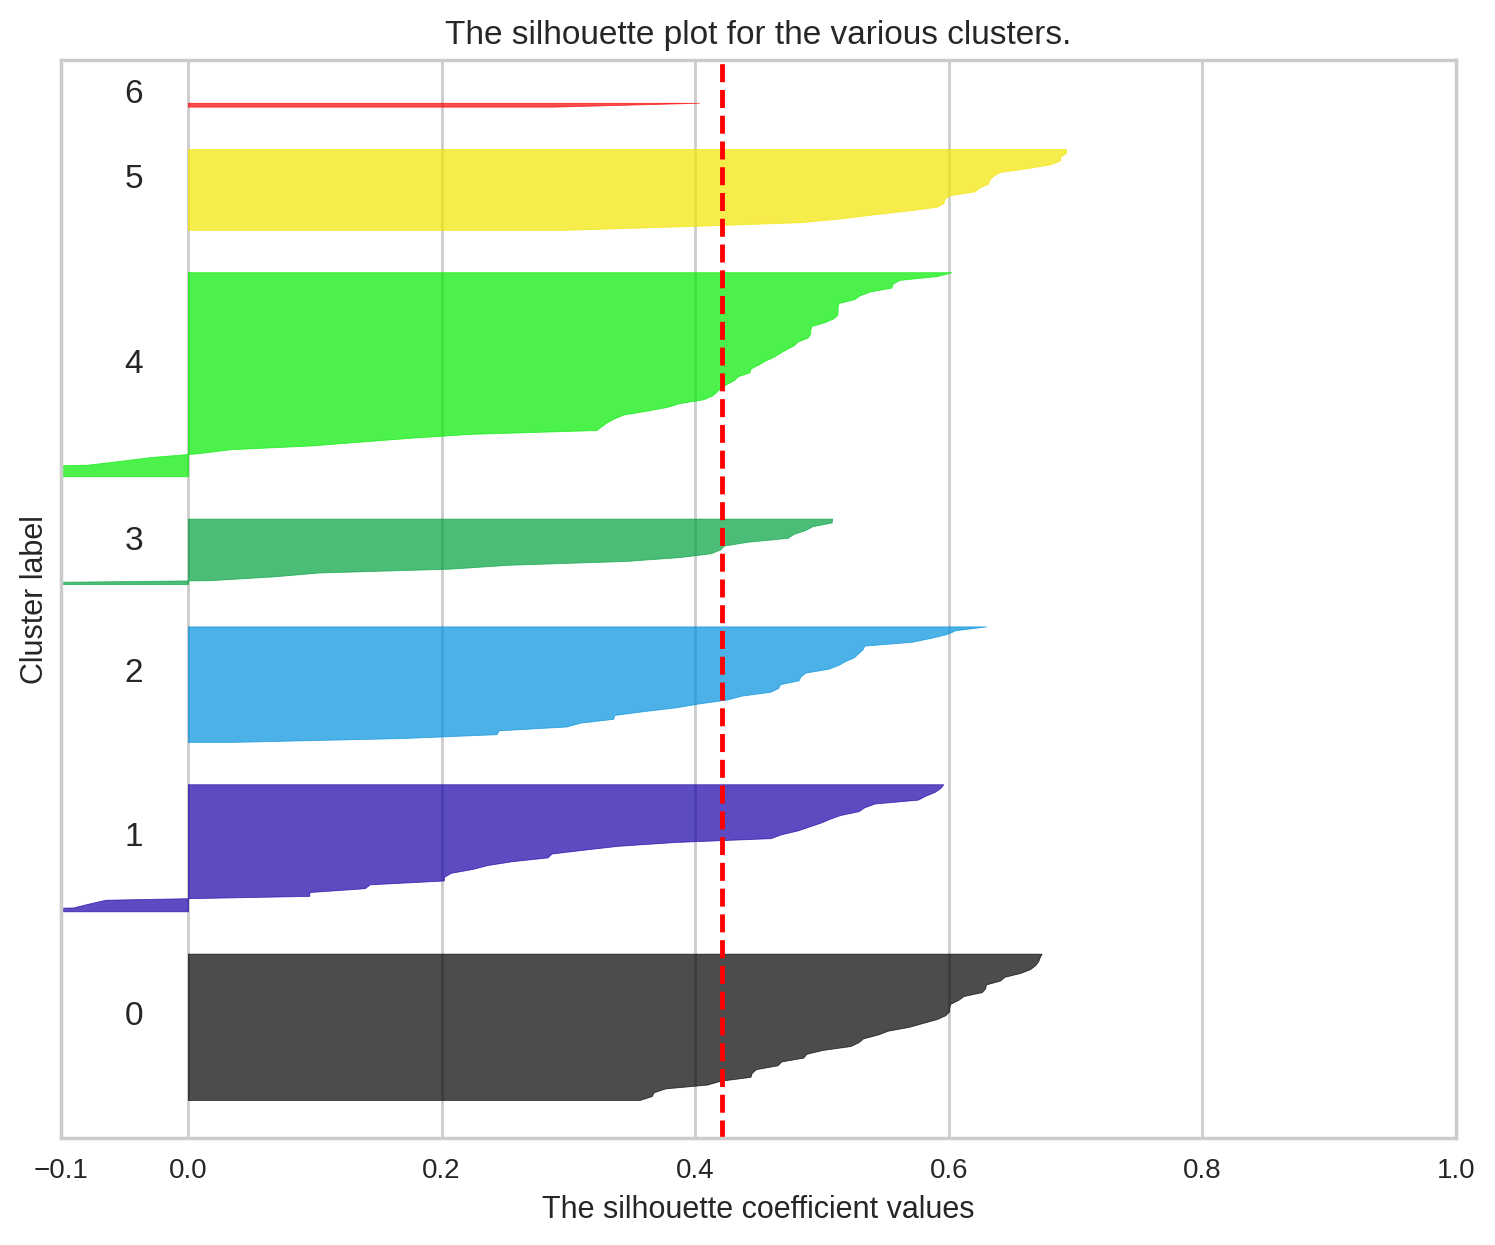

In [29]:
# Loop through the desired number of clusters
for n_clusters in range(3, 8):
    # Create and fit the Agglomerative Clustering model
    clusterer = AgglomerativeClustering(n_clusters=n_clusters, linkage='average')
    cluster_labels = clusterer.fit_predict(data_scaled)

    # Calculate and print the average silhouette score
    silhouette_avg = silhouette_score(data_scaled, cluster_labels)
    print(f"For n_clusters = {n_clusters}, the average silhouette score is {silhouette_avg}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(data_scaled, cluster_labels)

    # Create a subplot with 1 row and 1 column
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(9, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(data_scaled) + (n_clusters + 1) * 10])

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.show()

**Written Answer:** How many clusters were select based on the Silhouette analysis? Explain your answer.

The number of clusters selected based on hte Silhouette analysis is 6. 6 is the optimal number because it has the highest average silhouette score (0.43019501486902373) and a higher score indicates better clustering. The silhouette scores increase slightly as the number of clusters increases, but after 6 clusters, the score starts to decrease, suggesting that further increasing the number of clusters might not significantly improve the quality of the clustering and could lead to overfitting. Therefore, based on the Silhouette analysis and the principle of maximizing the silhouette score while avoiding overfitting, 6 clusters appear to be the optimal choice for this dataset using Agglomerative Clustering with average linkage.

7. Fit the Agglomerative clustering on the scaled data using the optimal number of clusters identified in Q6. Then, visualize the resulting clusters using scatterplots.

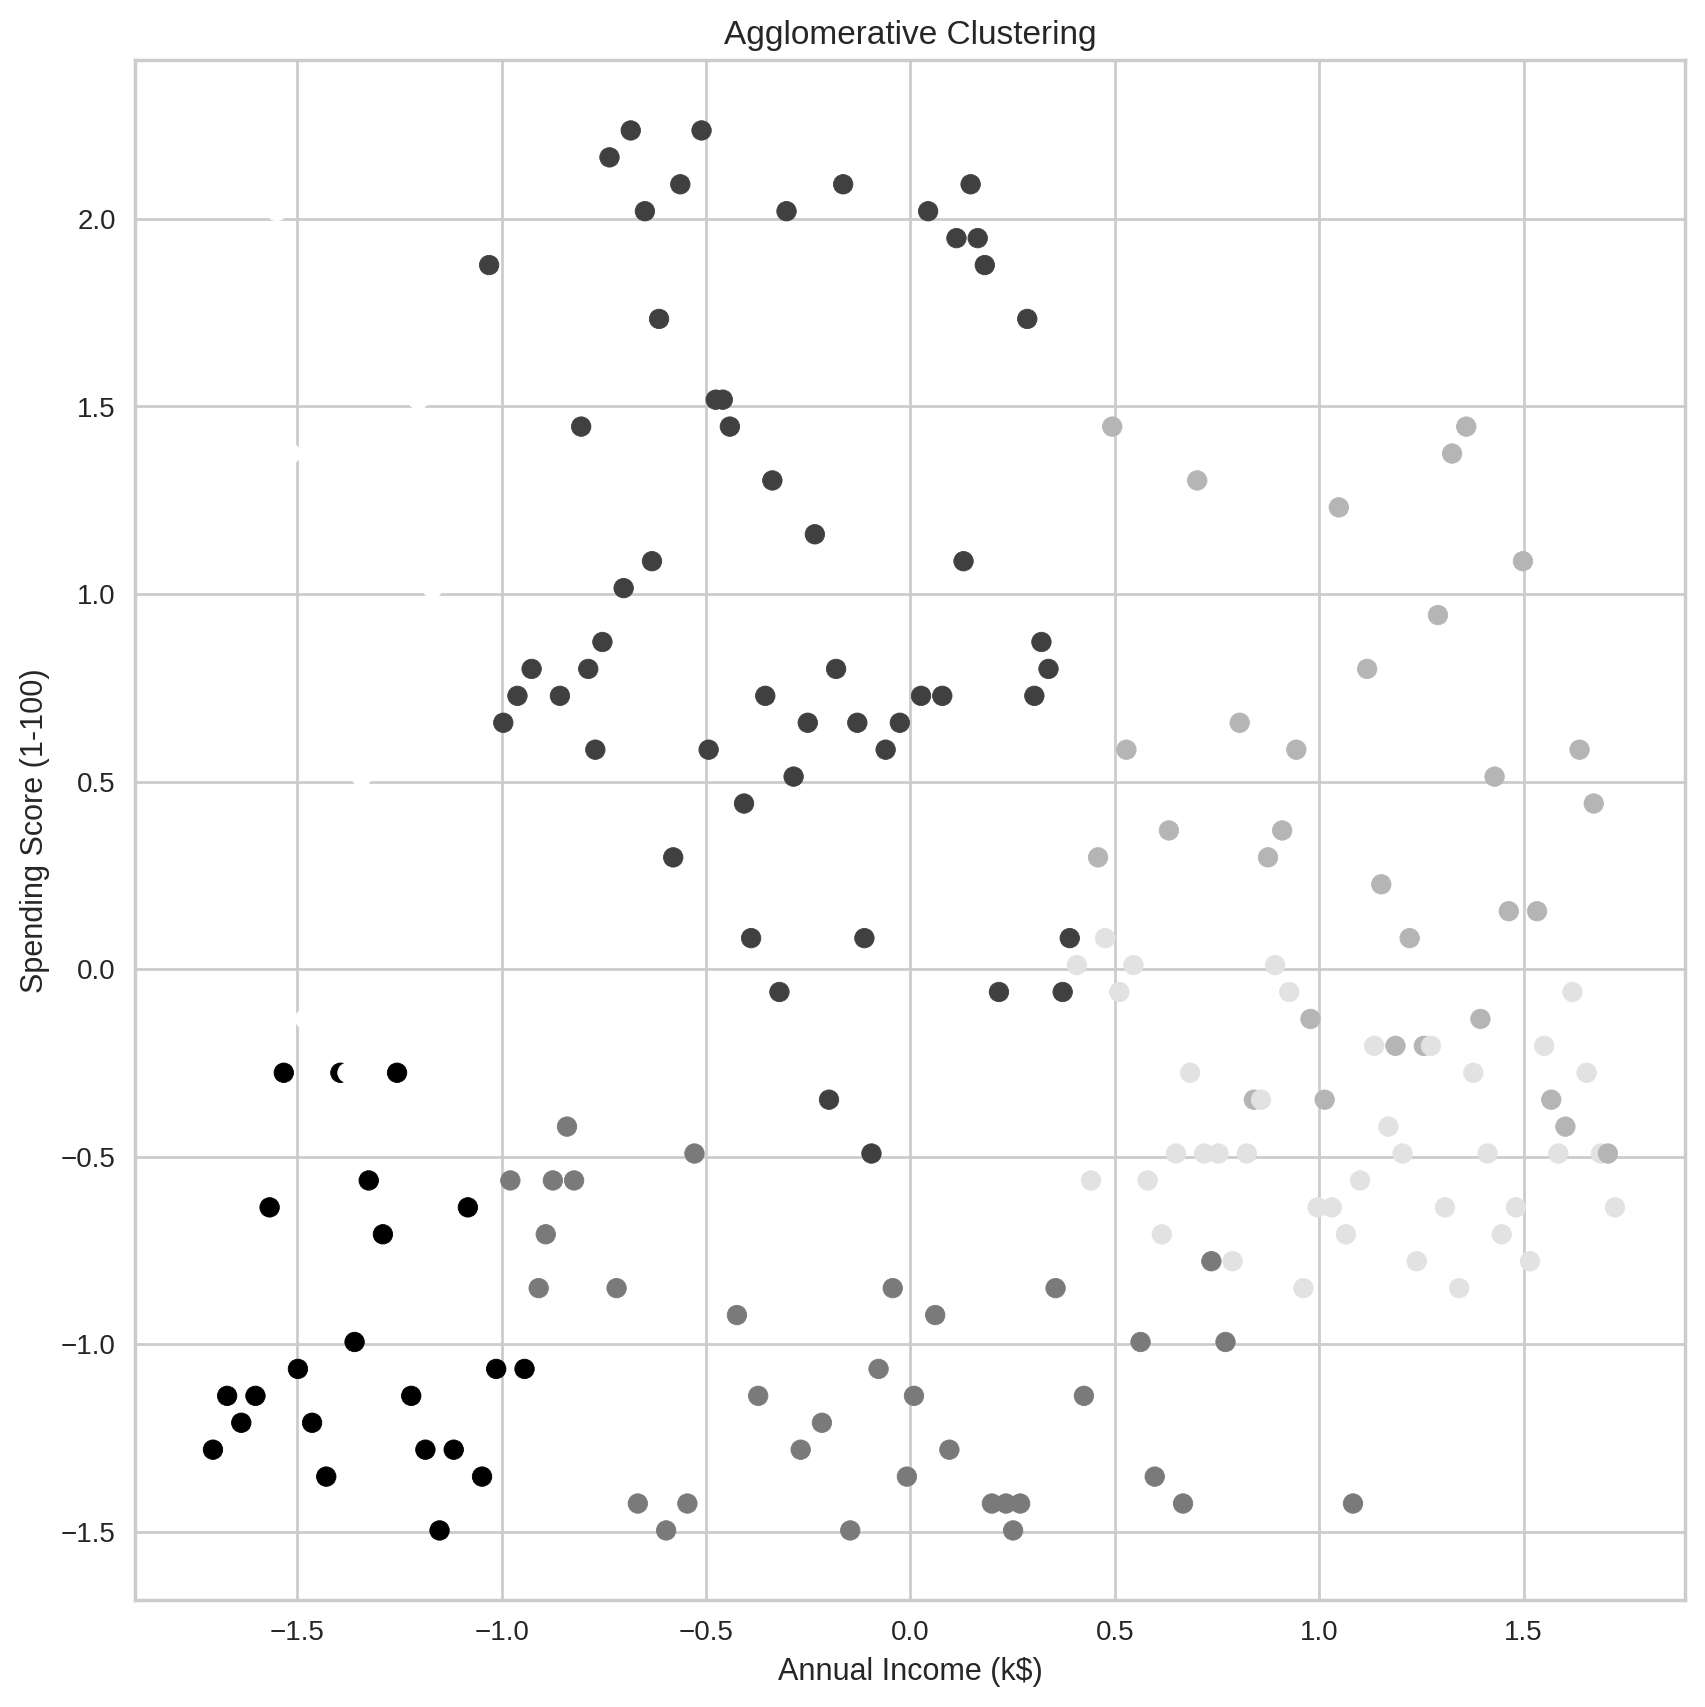

In [37]:
# Fit the Agglomerative clustering on the scaled data using the optimal number of clusters identified in Q6
clusterer = AgglomerativeClustering(n_clusters=6, linkage='average')
cluster_labels = clusterer.fit_predict(data_scaled)

# Visualize the resulting clusters using scatterplots
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.scatter(data_scaled[:, 0], data_scaled[:, 1], c=cluster_labels)
ax.set_xlabel('Annual Income (k$)')
ax.set_ylabel('Spending Score (1-100)')
ax.set_title('Agglomerative Clustering')
plt.show()

8. Using the clusters from Q7, create a table showing the average values per variable (Age, Annual income, and Spending scores) for each cluster. Use the original, non-scaled variables. Interpret the characteristics of each cluster.

In [41]:
# Using the clusters from Q7, create a table showing the average values per variable for each cluster
data_pd['cluster'] = cluster_labels
data_pd.groupby('cluster').mean()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
cluster,,,,
0,20.000000,43.900000,24.450000,19.100000
1,162.000000,32.692308,86.538462,82.128205
2,166.870968,44.387097,89.774194,18.483871
3,94.352941,23.794118,58.000000,44.529412
4,83.203704,53.259259,54.203704,48.555556
5,23.090909,25.272727,25.727273,79.363636


**Cluster 0**: This cluster represents the lowest income, and pretty much the lowest spending score. These middle-aged people are probably budget conscious because they don't have a lot of money to spend. Their kids are probably in post-secondary education and they are supporting their tuition.

**Cluster 1**: Highest spending score and almost the highest income. This cluster probably doens't contain any retired folks so the average income is veyr high. They are at the age of being married with kids, which is probably what contributes to their high spending habits.

**Cluster 2**: Group with the highest income but lowest spending score. Even though they are on average older than the 0th cluster, they probably contain less old grandpas and so they have a very high annual income. They are also at an age where they have become conscious of their budgets. For the ones with kids, their kdis might be financially indpendent, lowering the spending score of the parentals.

**Cluster 3**: Youngest group with average incomes and spending scores. They are at the age where some have just graudated from post-secondary education and some might still be either pursuing their degree or going back for another. For the ones that chose the institution route, they are making entry level, contributing to their average-level income. These fresh adults are also settling into their mature lives where they are figuring out where they can save and where they can afford leisures. Some are also paying rent for student housing while some are just buying their first house.

**Cluster 4**: Oldest group with an average income and spending score. Just like cluster 3 having just transitioned into adulthood, these grey-haired homosapiens have just transitioned into grandparenthood, and possibly retirement homes. For the ones blessed with mini homosapiens, they might be helping to pay for cute baby clothes and maybe driving to see them. There's probably a decent portion of this cluster that ahve high medical bills due to their high age.

**Cluster 5**: Very young, very low income, and very high spending score. Education is expensive man. Also rent like what. It's hard to afford while working only part-time.

## Spectral Clustering

9. Use Spectral Clustering to determine the best number of clusters (between 3 and 8) using silhouette analysis.

Set the parameters:
- `affinity = 'nearest_neighbors'`
- `n_jobs = -1`
- `n_neighbors = 10`
- `random_state = 2025`


For each number of clusters:

- Compute and display the average silhouette score
- Generate the silhouette plot.



For n_clusters = 3, the average silhouette score is 0.35763797301850536


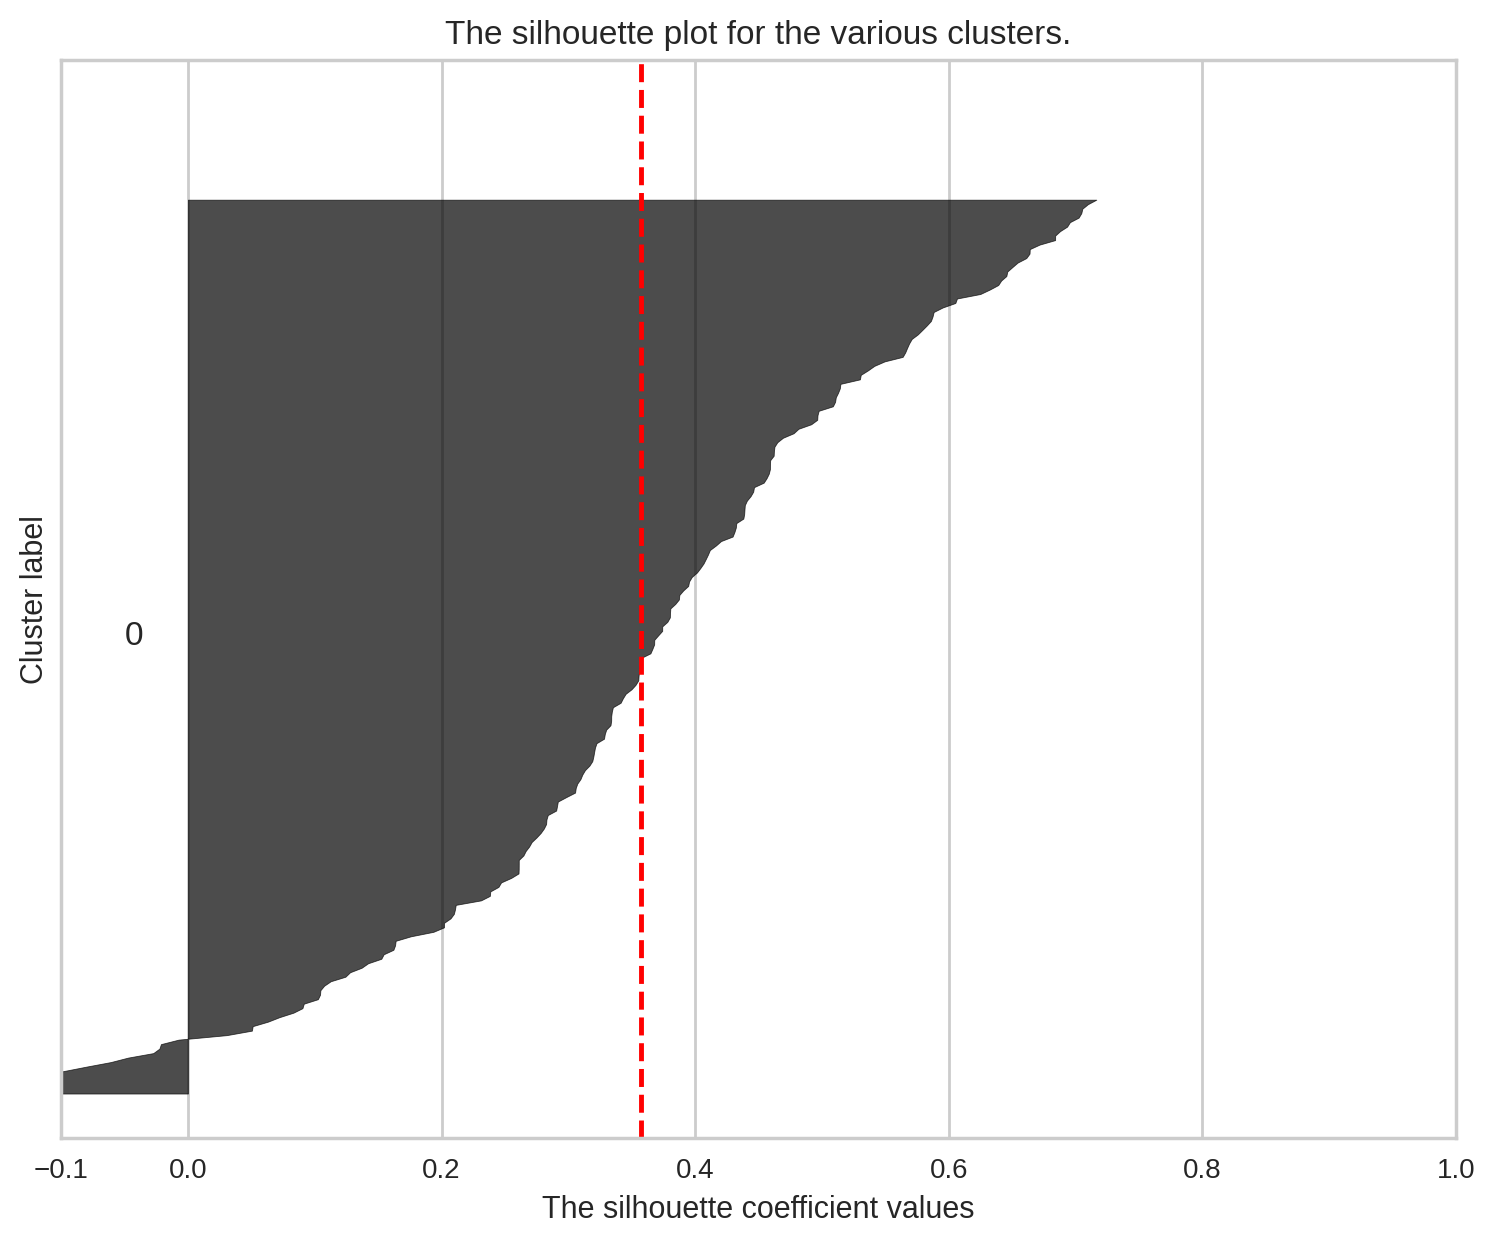

For n_clusters = 4, the average silhouette score is 0.3839289340011585


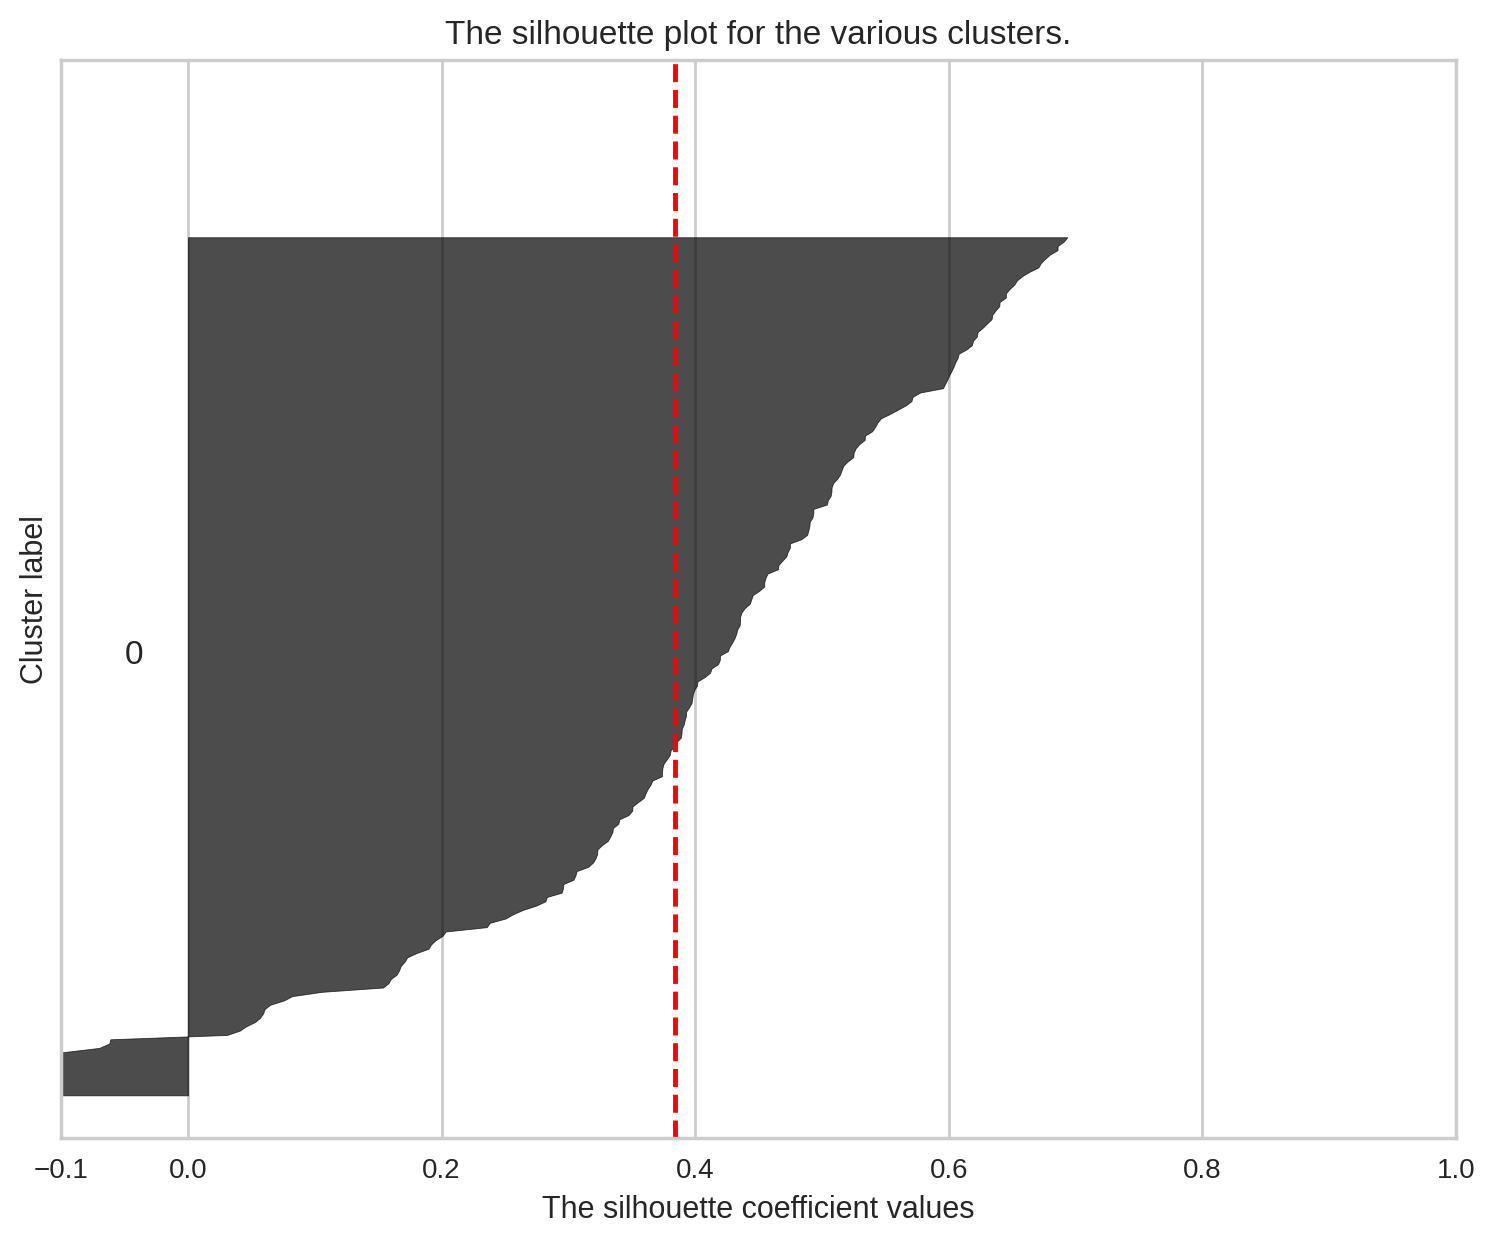

For n_clusters = 5, the average silhouette score is 0.3808850058217837


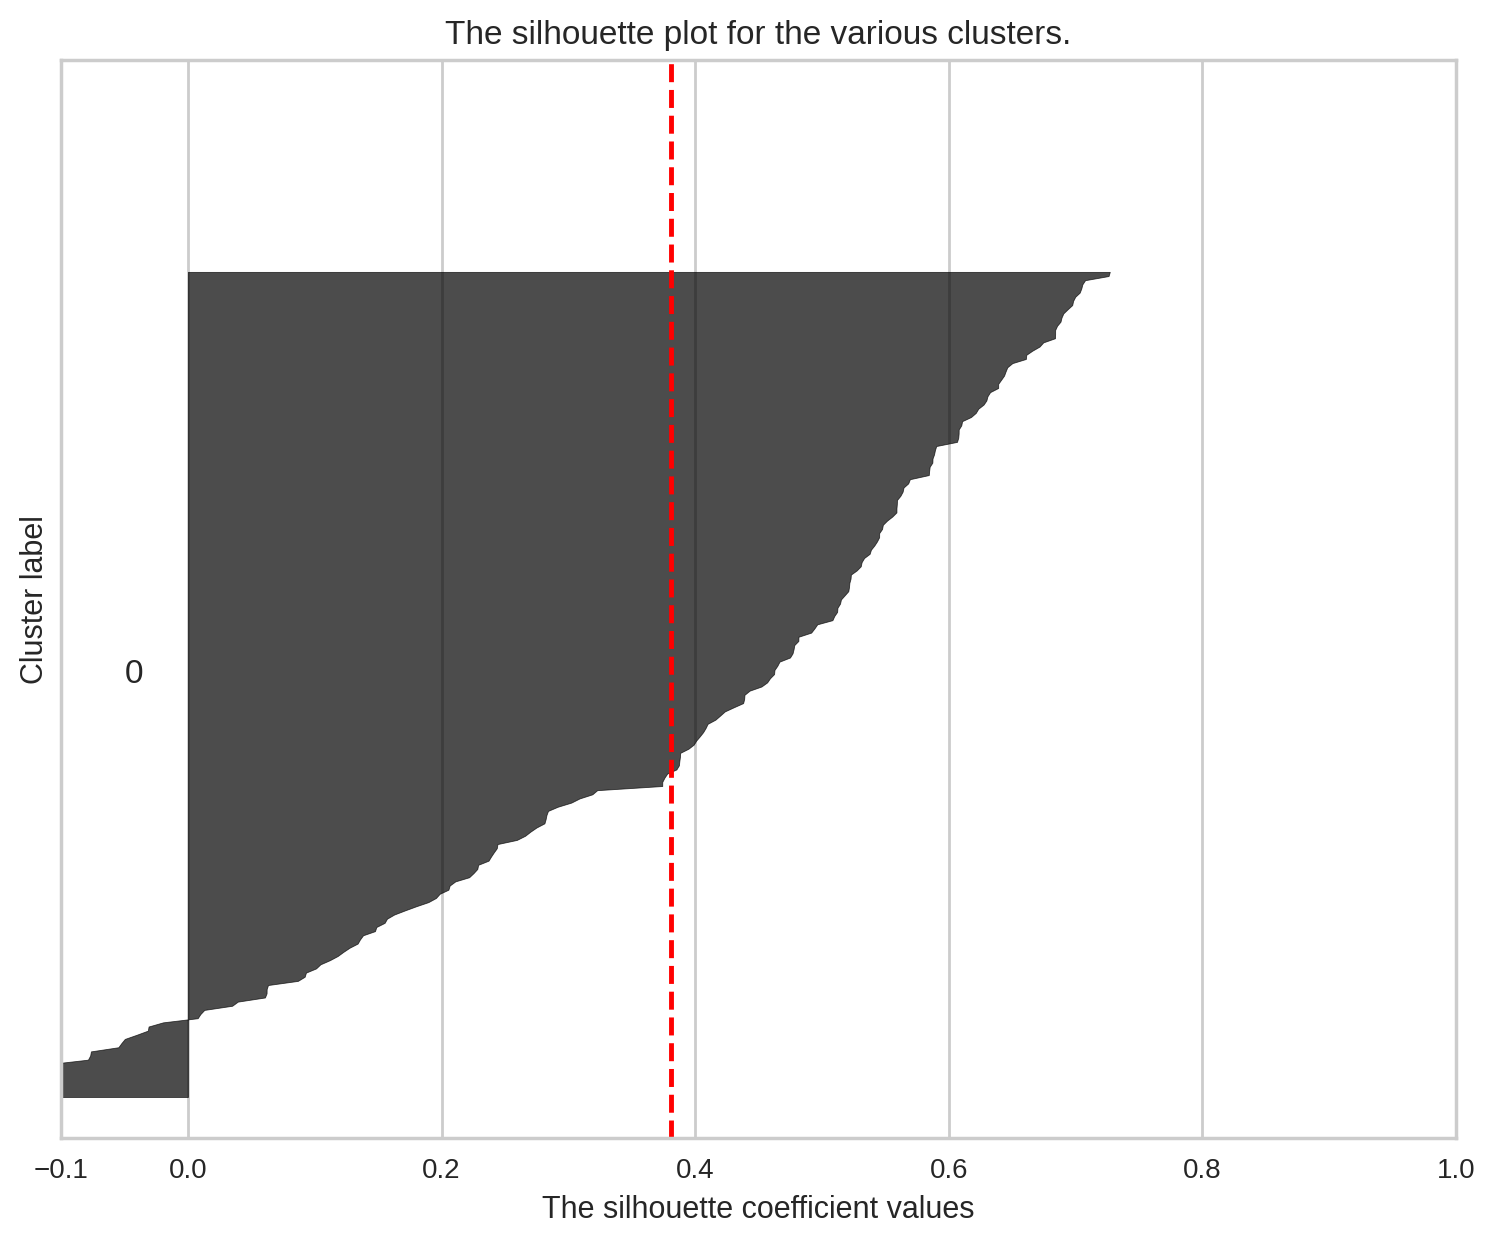

For n_clusters = 6, the average silhouette score is 0.4359420659276762


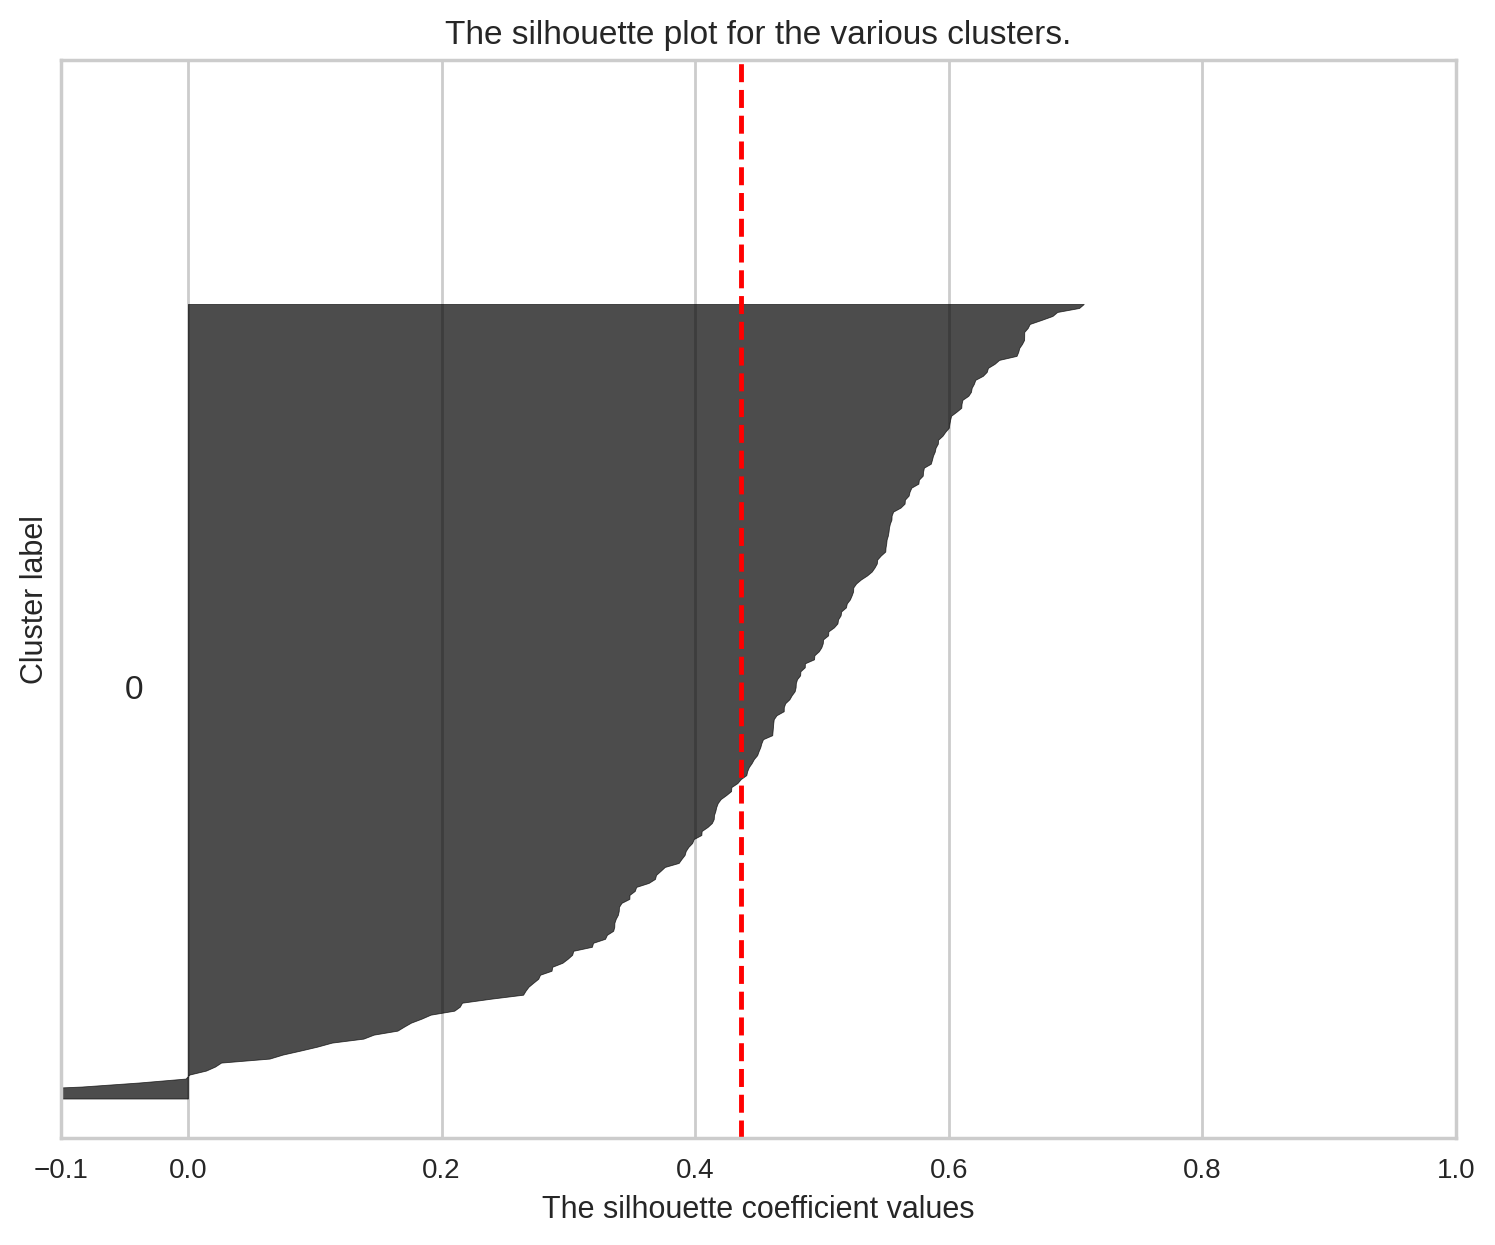

For n_clusters = 7, the average silhouette score is 0.41385061038538057


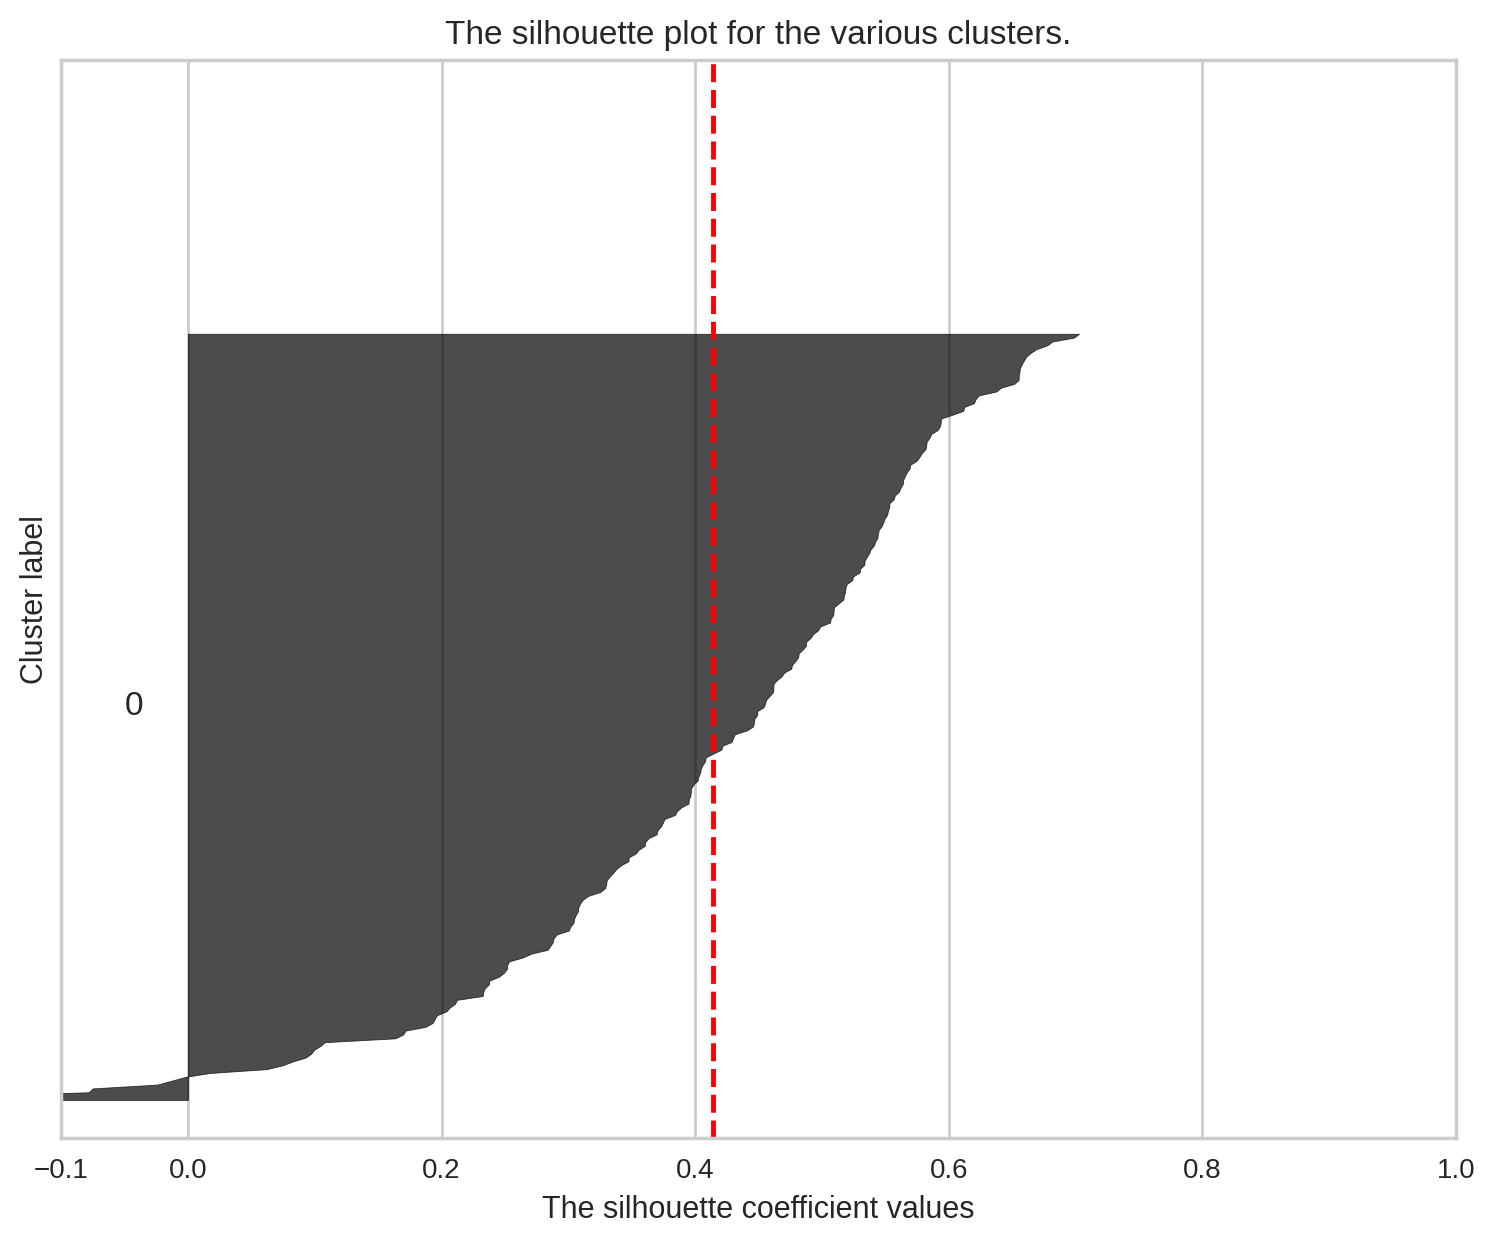

For n_clusters = 8, the average silhouette score is 0.38099168968637637


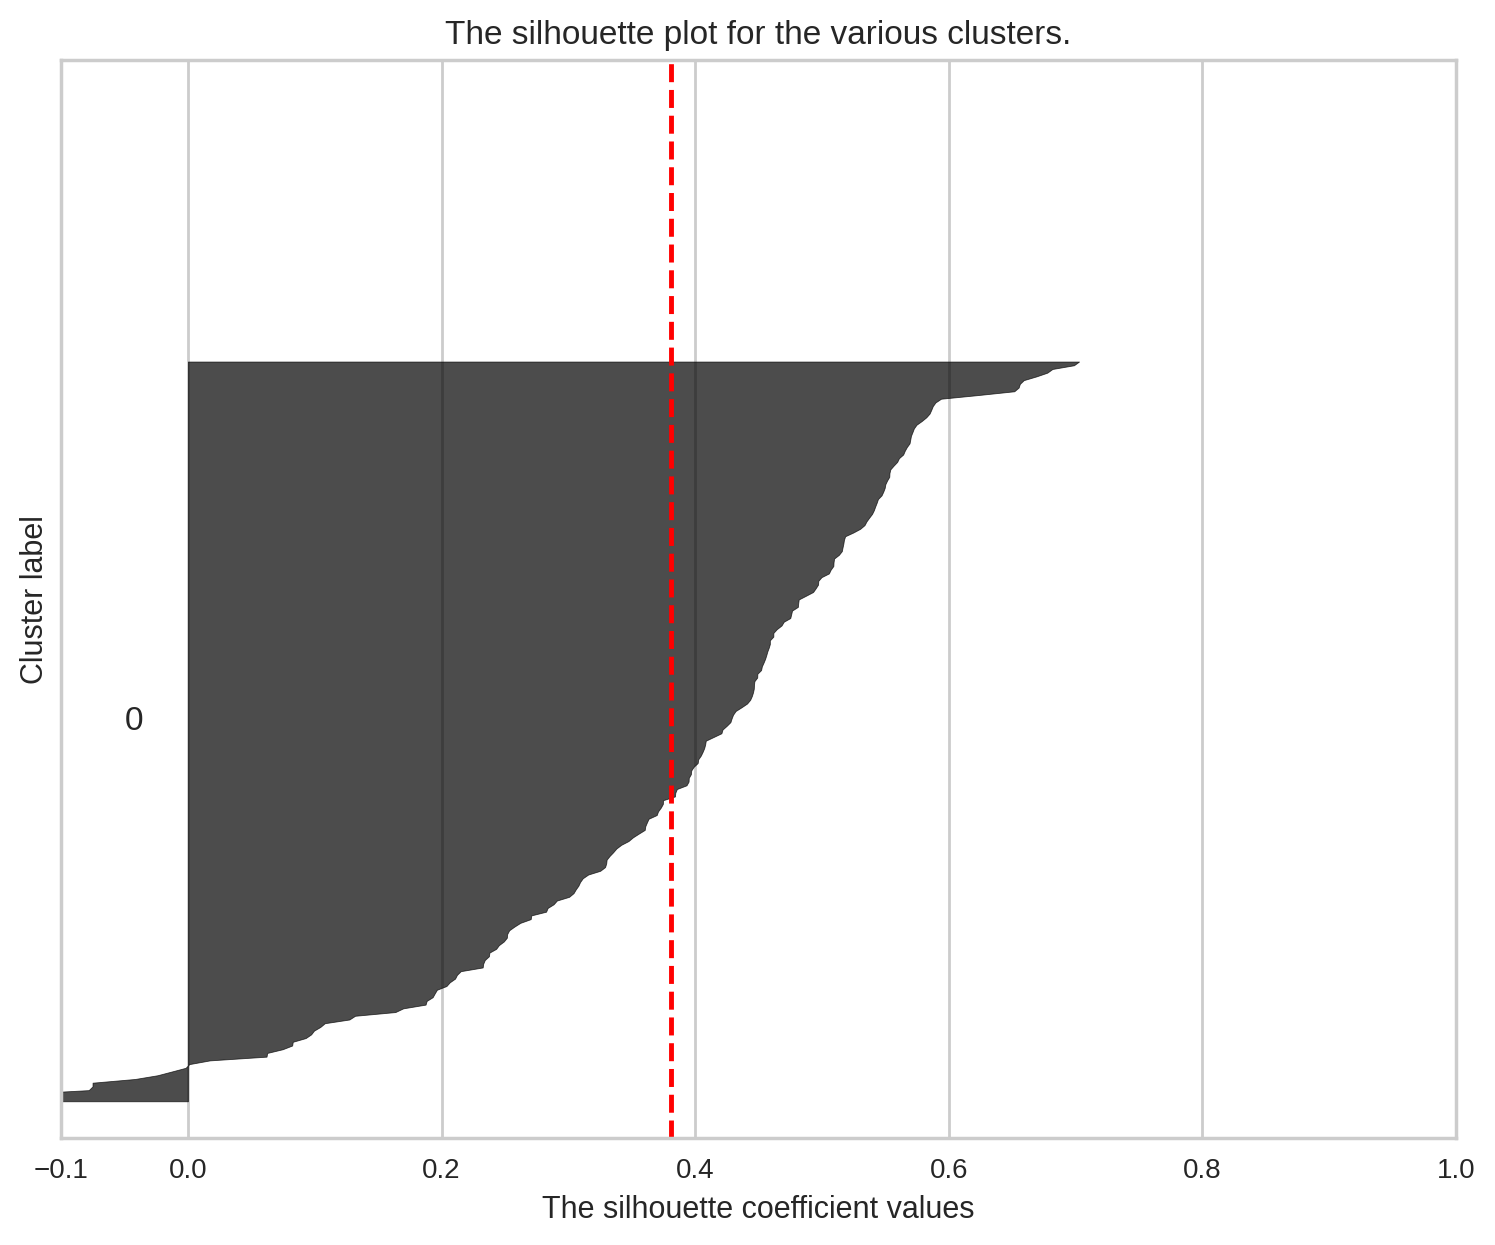

In [46]:
# Set the parameters
affinity = 'nearest_neighbors'
n_jobs = -1
n_neighbors = 10
random_state = 2025

# Loop through the desired number of clusters
for n_clusters in range(3, 9):
    # Create and fit the Spectral Clustering model
    clusterer = SpectralClustering(n_clusters=n_clusters, affinity=affinity, n_jobs=n_jobs, n_neighbors=n_neighbors, random_state=random_state)
    cluster_labels = clusterer.fit_predict(data_scaled)

    # Compute and display the average silhouette score
    silhouette_avg = silhouette_score(data_scaled, cluster_labels)
    print(f"For n_clusters = {n_clusters}, the average silhouette score is {silhouette_avg}")

    # Create silhouette plot
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(9, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(data_scaled) + (n_clusters + 1) * 10])
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = silhouette_samples(data_scaled, cluster_labels)
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

        # Add titles and labels to the silhouette plot
        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # Add a vertical line for the average silhouette score
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        # Clear the y-axis labels / ticks and set the x-axis ticks
        ax1.set_yticks([])
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # Show the plot
        plt.show()

**Written Answer:** How many clusters were select based on the Silhouette analysis? Explain your answer.

The number of clusters selected based on the Silhouette analysis is once again 6. This is because it once again has the highest silhouette score of 0.4359420659276762. Same reasoning and previously stated as well.

10. Fit a Spectral Clustering on the scaled data using the optimal number of clusters identified in Q9. Then, visualize the resulting clusters using scatterplots.

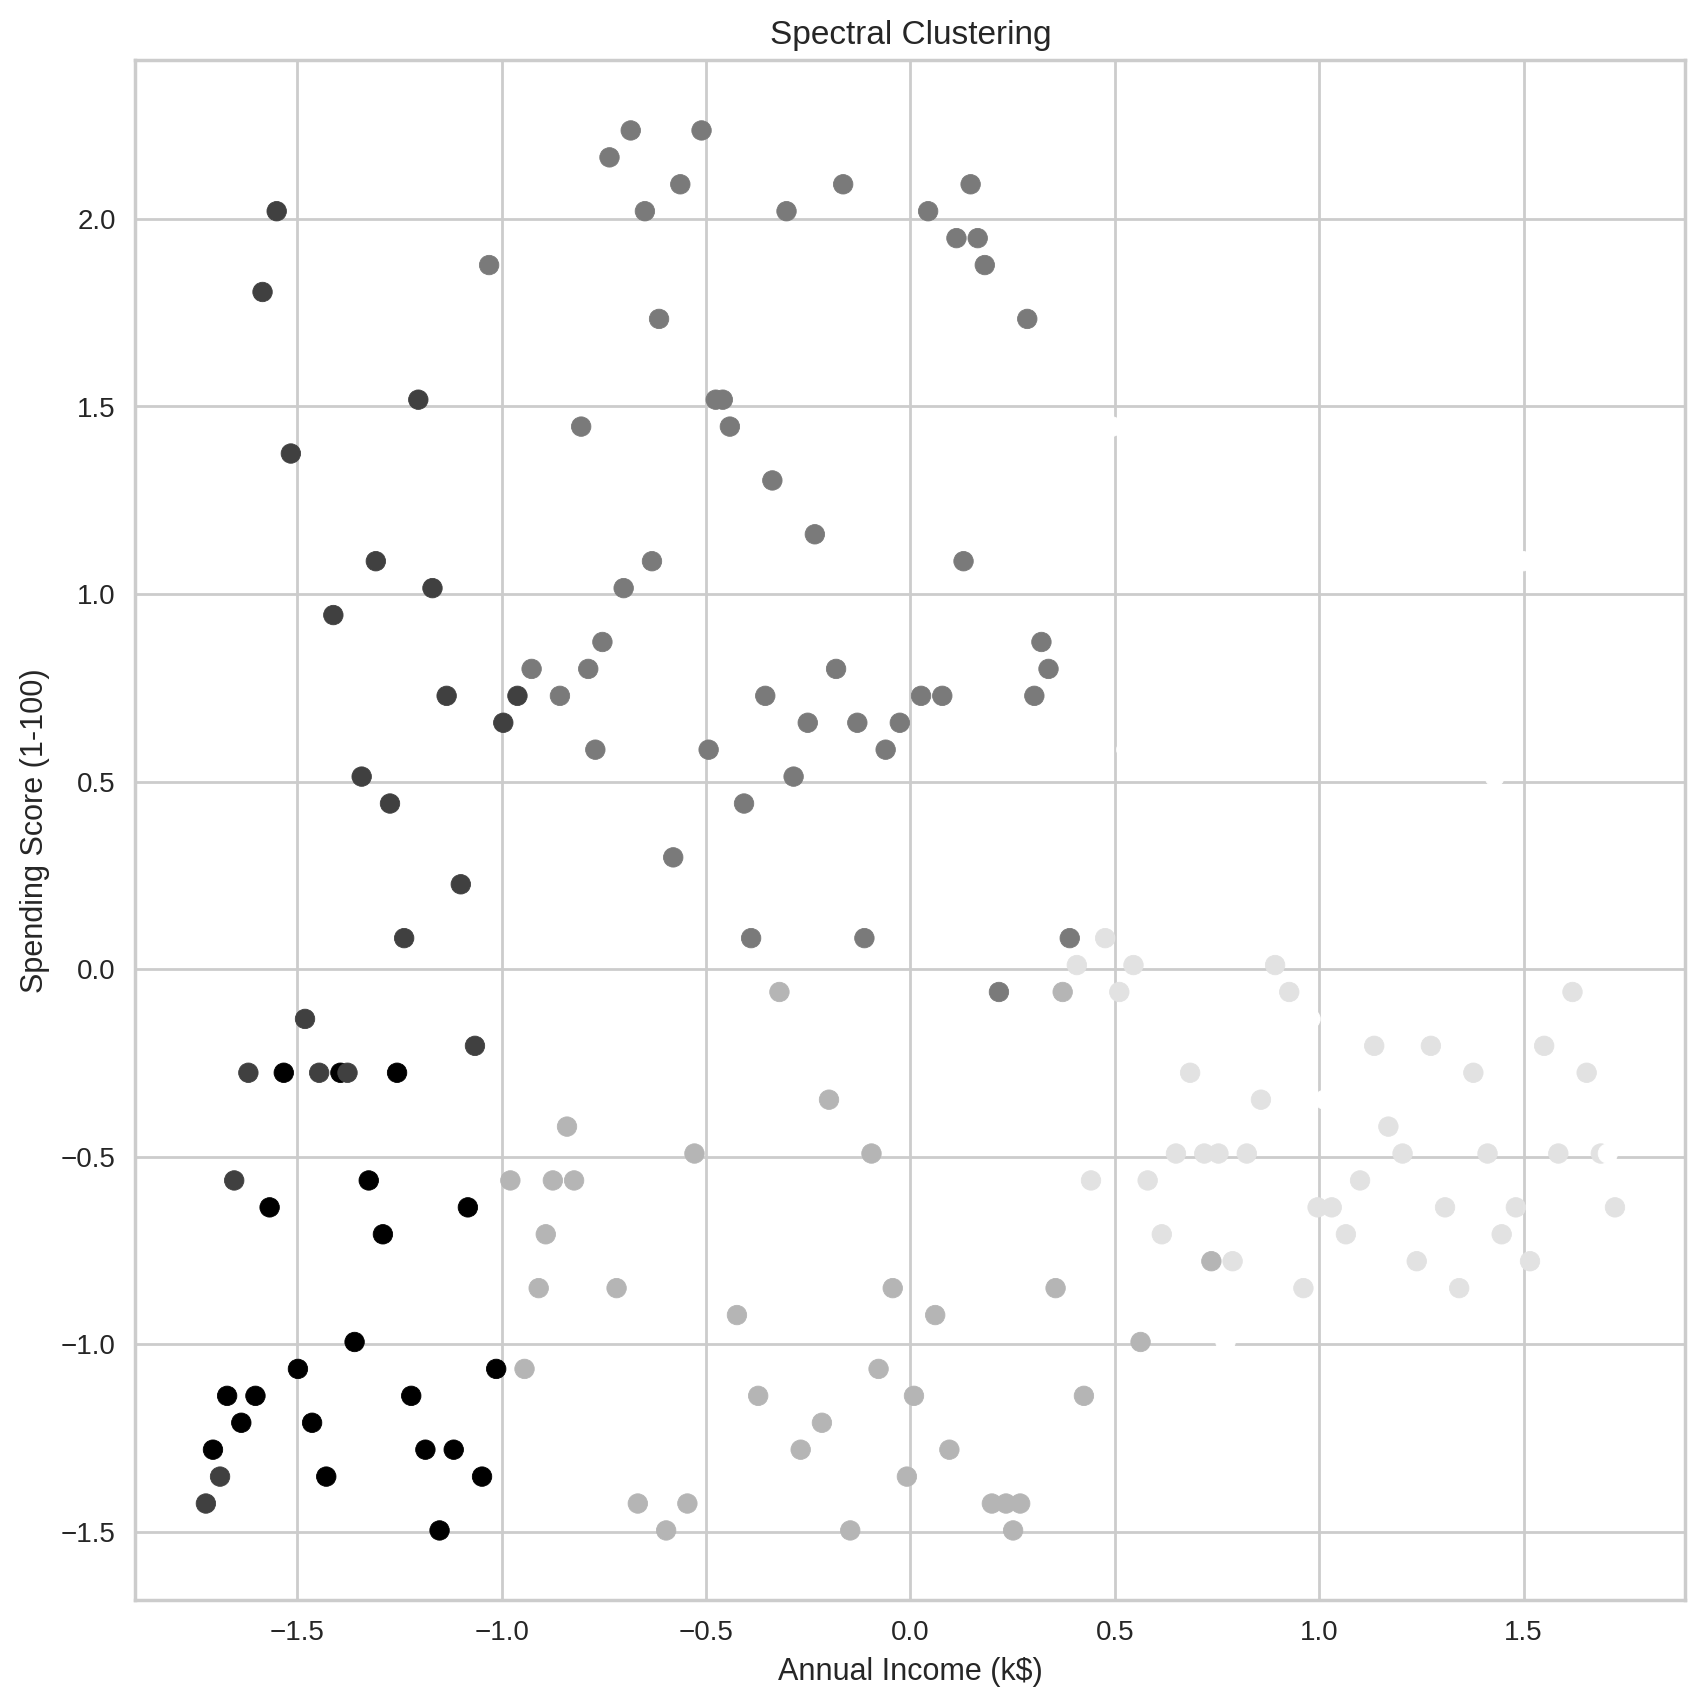

In [48]:
# Fit a Spectral CLustering on the scaled data using the optimal number of clusters in Q9
clusterer = SpectralClustering(n_clusters=6, affinity=affinity, n_jobs=n_jobs, n_neighbors=n_neighbors, random_state=random_state)
cluster_labels = clusterer.fit_predict(data_scaled)

# Visualize the resulting clusters using scatterplots
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.scatter(data_scaled[:, 0], data_scaled[:, 1], c=cluster_labels)
ax.set_xlabel('Annual Income (k$)')
ax.set_ylabel('Spending Score (1-100)')
ax.set_title('Spectral Clustering')
plt.show()

11. Using the clusters from Q10, create a table showing the average values per variable (Age, Annual income, and Spending scores) for each cluster. Use the original, non-scaled variables. Interpret the characteristics of each cluster.

In [51]:
# Using the clusters from Q10, create a table showing the average values per variable for each cluster
data_pd['cluster'] = cluster_labels
data_pd.groupby('cluster').mean()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
cluster,,,,
0,164.428571,41.685714,88.228571,17.285714
1,162.000000,32.692308,86.538462,82.128205
2,87.428571,25.485714,55.571429,49.828571
3,83.687500,54.937500,54.375000,49.187500
4,22.181818,44.318182,25.772727,20.272727
5,22.000000,25.333333,25.095238,80.047619


**Written answer:**

**Cluster 0**:
- high income
- low spending
- average age is about 42

**Cluster 1**:
- high income
- high spending
- average age is around 33

**Cluster 2**:
- moderate income
- moderate spending
- average age is around 25

**Cluster 3**:
- moderate income
- moderate spending
- average age is around 55

**Cluster 4**:
- low income
- low spending
- average age is around 44

**Cluster 5**:
- low income
- low spending
- average age is around 25

12. Compare the results obtained using the Agglomerative Clustering and the Spectral Clustering methods. Comment your findings.

**Written answer:**

**Agglomerative Clustering**: Focused on local density and proximity, potentially leading to clusters with more omogenous age demographics within each income/spending segment. Placed the low-income/low-spending and high-income/low-spending in separate clusters (Clusters 0 and 2), suggesting that this method considers both income and spending behaviour in it's analysis.

**Spectral Clustering**: COnsidered the global structure of the data, resulting in clusters that are more diverse in terms of age but still share similar income and psending patterns. Placed the low-income/low-spending and high-income/low-spending into a single cluster (Cluster 0), suggesting that this method is more sensitive to the overall income level.

**Similarities**: Both methods produced 6 clusters when using Silhouette analysis for determining the optimal number of clusters. This suggests that both methods identified similar underlying structures in the data. In general, both methods identifies similar clusters representing high-income/high-spending individuals (Cluster 1) and low-income/high-spending individuals (Cluster 5). This suggests that these customer segments are relatively distinct and easily identifiable by both algorithms.